# **Import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate

from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

# **Data**

In [2]:
# Read data from CSV file
data = pd.read_csv('/cancer-data-csv.csv', delimiter=';')
df = data
data.head()

Patient Id  Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0         P1   33       1              2            4             5   
1        P10   17       1              3            1             5   
2       P100   35       1              4            5             6   
3      P1000   37       1              7            7             7   
4       P101   46       1              6            8             7   

   OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                     4             3                     2              2   
1                     3             4                     2              2   
2                     5             5                     4              6   
3                     7             6                     7              7   
4                     7             7                     6              7   

   ...  Fatigue  Weight Loss  Shortness of Breath  Wheezing  \
0  ...        3            4                    2         2   
1  ...        1            3                    7         8   
2  ...        8            7                    9         2   
3  ...        4            2                    3         1   
4  ...        3            2                    4         1   

   Swallowing Difficulty  Clubbing of Finger Nails  Frequent Cold  Dry Cough  \
0                      3                         1              2          3   
1                      6                         2              1          7   
2                      1                         4              6          7   
3                      4                         5              6          7   
4                      4                         2              4          2   

   Snoring   Level  
0        4     Low  
1        2  Medium  
2        2    High  
3        5    High  
4        3    High  

[5 rows x 25 columns]

In [3]:
print(data.describe())

               Age       Gender  Air Pollution  Alcohol use  Dust Allergy  \
count  1000.000000  1000.000000      1000.0000  1000.000000   1000.000000   
mean     37.174000     1.402000         3.8400     4.563000      5.165000   
std      12.005493     0.490547         2.0304     2.620477      1.980833   
min      14.000000     1.000000         1.0000     1.000000      1.000000   
25%      27.750000     1.000000         2.0000     2.000000      4.000000   
50%      36.000000     1.000000         3.0000     5.000000      6.000000   
75%      45.000000     2.000000         6.0000     7.000000      7.000000   
max      73.000000     2.000000         8.0000     8.000000      8.000000   

       OccuPational Hazards  Genetic Risk  chronic Lung Disease  \
count           1000.000000   1000.000000           1000.000000   
mean               4.840000      4.580000              4.380000   
std                2.107805      2.126999              1.848518   
min                1.000000      1.000

# **Standard Preparation**

In [4]:
# Check for missing values
print(data.isnull().sum())

# Remove rows with missing values
data = data.dropna()

Patient Id                  0
Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64


In [5]:
X = data.drop(['Patient Id', 'Level'], axis=1)
y = data['Level']

feature_names = X.columns

In [6]:
class_names = []

# Label Encoding for target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

for i, label in enumerate(label_encoder.classes_):
    class_names.append(label)
    print(f'{label} -> {i}')

High -> 0
Low -> 1
Medium -> 2


In [7]:
class_names

['High', 'Low', 'Medium']

In [8]:
X_df = pd.DataFrame(X, columns=X.columns)
y_s = pd.Series(y, name='Level')
data = pd.concat([X_df, y_s], axis=1)

# **Oversampling**

In [9]:
# display the number of occurrences of each cancer level
level_counts = data['Level'].value_counts()
print(level_counts)

0    365
2    332
1    303
Name: Level, dtype: int64


As we have relatively very little data, we will use SMOTE and Borderline-SMOTE to generate new additional synthetic data. Increasing the records from **1 000 to 17 392** records

In [10]:
X_i = data.drop(['Level'], axis=1)
y_i = data['Level']

# apply SMOTE to generate synthetic data points
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_i, y_i)

# convert the resampled data to DataFrame and Series objects
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Level')

# create a new DataFrame with the resampled data
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# append the resampled data to the original DataFrame
data = pd.concat([data, data_resampled], axis=0)
data

Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      33       1              2            4             5   
1      17       1              3            1             5   
2      35       1              4            5             6   
3      37       1              7            7             7   
4      46       1              6            8             7   
...   ...     ...            ...          ...           ...   
1090   52       1              6            8             7   
1091   35       1              2            1             5   
1092   39       1              4            5             6   
1093   48       2              6            8             7   
1094   32       2              1            6             7   

      OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                        4             3                     2              2   
1                        3             4                     2              2   
2                        5             5                     4              6   
3                        7             6                     7              7   
4                        7             7                     6              7   
...                    ...           ...                   ...            ...   
1090                     7             7                     6              2   
1091                     3             2                     3              2   
1092                     6             5                     4              6   
1093                     7             7                     6              2   
1094                     8             7                     6              7   

      Obesity  ...  Fatigue  Weight Loss  Shortness of Breath  Wheezing  \
0           4  ...        3            4                    2         2   
1           2  ...        1            3                    7         8   
2           7  ...        8            7                    9         2   
3           7  ...        4            2                    3         1   
4           7  ...        3            2                    4         1   
...       ...  ...      ...          ...                  ...       ...   
1090        4  ...        2            7                    6         5   
1091        4  ...        6            7                    2         5   
1092        6  ...        5            3                    2         4   
1093        4  ...        2            7                    6         5   
1094        7  ...        3            2                    6         4   

      Swallowing Difficulty  Clubbing of Finger Nails  Frequent Cold  \
0                         3                         1              2   
1                         6                         2              1   
2                         1                         4              6   
3                         4                         5              6   
4                         4                         2              4   
...                     ...                       ...            ...   
1090                      1                         9              3   
1091                      8                         1              3   
1092                      3                         1              7   
1093                      1                         9              3   
1094                      2                         3              1   

      Dry Cough  Snoring  Level  
0             3        4      1  
1             7        2      2  
2             7        2      0  
3             7        5      0  
4             2        3      0  
...         ...      ...    ...  
1090          4        2      2  
1091          2        3      2  
1092          5        6      2  
1093          4        2      2  
1094          2        1      2  

[2095 rows x 24 columns]

In [11]:
X_i = data.drop(['Level'], axis=1)
y_i = data['Level']

# apply Borderline-SMOTE to generate synthetic data points
bsm = BorderlineSMOTE()
X_resampled, y_resampled = bsm.fit_resample(X_i, y_i)

# convert the resampled data to DataFrame and Series objects
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Level')

# create a new DataFrame with the resampled data
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# append the resampled data to the original DataFrame
data = pd.concat([data, data_resampled], axis=0)
data

Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      33       1              2            4             5   
1      17       1              3            1             5   
2      35       1              4            5             6   
3      37       1              7            7             7   
4      46       1              6            8             7   
...   ...     ...            ...          ...           ...   
2152   48       1              3            2             3   
2153   51       1              2            3             4   
2154   48       1              3            2             3   
2155   50       1              2            3             4   
2156   44       1              3            1             3   

      OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                        4             3                     2              2   
1                        3             4                     2              2   
2                        5             5                     4              6   
3                        7             6                     7              7   
4                        7             7                     6              7   
...                    ...           ...                   ...            ...   
2152                     2             1                     2              2   
2153                     3             2                     2              2   
2154                     2             1                     2              2   
2155                     3             2                     2              2   
2156                     3             2                     3              3   

      Obesity  ...  Fatigue  Weight Loss  Shortness of Breath  Wheezing  \
0           4  ...        3            4                    2         2   
1           2  ...        1            3                    7         8   
2           7  ...        8            7                    9         2   
3           7  ...        4            2                    3         1   
4           7  ...        3            2                    4         1   
...       ...  ...      ...          ...                  ...       ...   
2152        2  ...        2            5                    1         2   
2153        3  ...        2            4                    1         2   
2154        2  ...        2            5                    1         2   
2155        3  ...        2            4                    1         2   
2156        3  ...        2            2                    2         3   

      Swallowing Difficulty  Clubbing of Finger Nails  Frequent Cold  \
0                         3                         1              2   
1                         6                         2              1   
2                         1                         4              6   
3                         4                         5              6   
4                         4                         2              4   
...                     ...                       ...            ...   
2152                      3                         1              1   
2153                      3                         1              1   
2154                      3                         1              1   
2155                      3                         1              1   
2156                      2                         2              3   

      Dry Cough  Snoring  Level  
0             3        4      1  
1             7        2      2  
2             7        2      0  
3             7        5      0  
4             2        3      0  
...         ...      ...    ...  
2152          2        3      1  
2153          2        3      1  
2154          2        3      1  
2155          2        3      1  
2156          3        2      1  

[4252 rows x 24 columns]

In [12]:
X_i = data.drop(['Level'], axis=1)
y_i = data['Level']

# apply SMOTE to generate synthetic data points
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_i, y_i)

# convert the resampled data to DataFrame and Series objects
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Level')

# create a new DataFrame with the resampled data
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# append the resampled data to the original DataFrame
data = pd.concat([data, data_resampled], axis=0)
data

Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      33       1              2            4             5   
1      17       1              3            1             5   
2      35       1              4            5             6   
3      37       1              7            7             7   
4      46       1              6            8             7   
...   ...     ...            ...          ...           ...   
4375   31       2              3            2             4   
4376   32       2              1            6             7   
4377   44       1              1            2             3   
4378   48       2              6            8             7   
4379   46       2              1            6             7   

      OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                        4             3                     2              2   
1                        3             4                     2              2   
2                        5             5                     4              6   
3                        7             6                     7              7   
4                        7             7                     6              7   
...                    ...           ...                   ...            ...   
4375                     2             3                     2              3   
4376                     8             7                     6              7   
4377                     4             2                     4              3   
4378                     7             7                     6              2   
4379                     5             3                     2              6   

      Obesity  ...  Fatigue  Weight Loss  Shortness of Breath  Wheezing  \
0           4  ...        3            4                    2         2   
1           2  ...        1            3                    7         8   
2           7  ...        8            7                    9         2   
3           7  ...        4            2                    3         1   
4           7  ...        3            2                    4         1   
...       ...  ...      ...          ...                  ...       ...   
4375        3  ...        4            5                    6         5   
4376        7  ...        3            2                    6         4   
4377        3  ...        4            1                    2         4   
4378        4  ...        2            7                    6         5   
4379        2  ...        3            3                    7         7   

      Swallowing Difficulty  Clubbing of Finger Nails  Frequent Cold  \
0                         3                         1              2   
1                         6                         2              1   
2                         1                         4              6   
3                         4                         5              6   
4                         4                         2              4   
...                     ...                       ...            ...   
4375                      5                         4              6   
4376                      2                         3              1   
4377                      6                         5              4   
4378                      1                         9              3   
4379                      4                         8              7   

      Dry Cough  Snoring  Level  
0             3        4      1  
1             7        2      2  
2             7        2      0  
3             7        5      0  
4             2        3      0  
...         ...      ...    ...  
4375          5        4      2  
4376          2        1      2  
4377          2        5      2  
4378          4        2      2  
4379          7        5      2  

[8632 rows x 24 columns]

In [13]:
X_i = data.drop(['Level'], axis=1)
y_i = data['Level']

# apply SMOTE to generate synthetic data points
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_i, y_i)

# convert the resampled data to DataFrame and Series objects
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Level')

# create a new DataFrame with the resampled data
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# append the resampled data to the original DataFrame
data = pd.concat([data, data_resampled], axis=0)
data

Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      33       1              2            4             5   
1      17       1              3            1             5   
2      35       1              4            5             6   
3      37       1              7            7             7   
4      46       1              6            8             7   
...   ...     ...            ...          ...           ...   
8755   23       1              3            2             4   
8756   73       1              5            6             6   
8757   52       1              6            8             7   
8758   32       2              1            6             7   
8759   14       1              2            4             5   

      OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                        4             3                     2              2   
1                        3             4                     2              2   
2                        5             5                     4              6   
3                        7             6                     7              7   
4                        7             7                     6              7   
...                    ...           ...                   ...            ...   
8755                     2             3                     2              3   
8756                     5             6                     5              6   
8757                     7             7                     6              2   
8758                     8             7                     6              7   
8759                     6             5                     5              4   

      Obesity  ...  Fatigue  Weight Loss  Shortness of Breath  Wheezing  \
0           4  ...        3            4                    2         2   
1           2  ...        1            3                    7         8   
2           7  ...        8            7                    9         2   
3           7  ...        4            2                    3         1   
4           7  ...        3            2                    4         1   
...       ...  ...      ...          ...                  ...       ...   
8755        3  ...        4            5                    6         5   
8756        5  ...        4            3                    6         2   
8757        4  ...        2            7                    6         5   
8758        7  ...        3            2                    6         4   
8759        6  ...        5            3                    2         1   

      Swallowing Difficulty  Clubbing of Finger Nails  Frequent Cold  \
0                         3                         1              2   
1                         6                         2              1   
2                         1                         4              6   
3                         4                         5              6   
4                         4                         2              4   
...                     ...                       ...            ...   
8755                      5                         4              6   
8756                      1                         2              1   
8757                      1                         9              3   
8758                      2                         3              1   
8759                      4                         7              2   

      Dry Cough  Snoring  Level  
0             3        4      1  
1             7        2      2  
2             7        2      0  
3             7        5      0  
4             2        3      0  
...         ...      ...    ...  
8755          5        4      2  
8756          6        2      2  
8757          4        2      2  
8758          2        1      2  
8759          1        6      2  

[17392 rows x 24 columns]

In [14]:
X = data.drop(['Level'], axis=1)
y = data['Level']
level_counts = data['Level'].value_counts()
print(level_counts)

0    5840
1    5778
2    5774
Name: Level, dtype: int64


# **Visualization**

## Visualization: Outliers

From the below analysis, we will see how the dataset consists of no outliers.

also, there are too many features to effectively analyze the data. We will make our analysis on subsets based on real-world assumed correlation (an acknowledged bias)

### Too Many Features

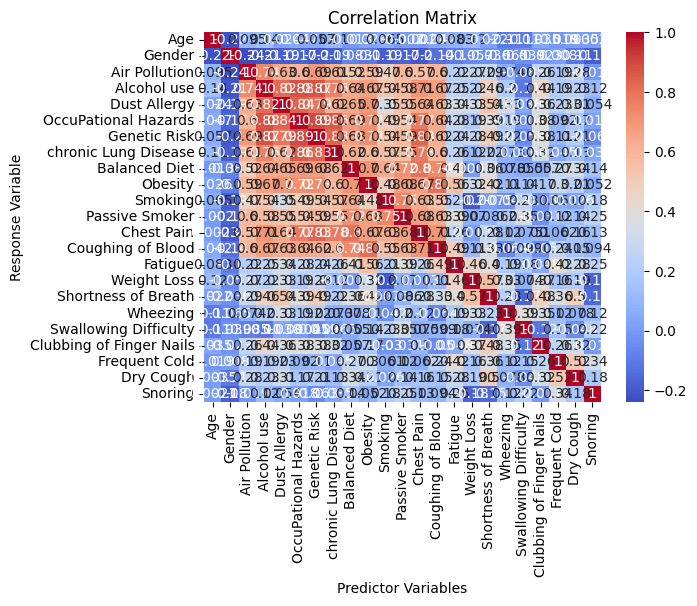

In [15]:
corr = X.corr()

# Create a heatmap to visualize the correlations
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Add plot title and axis labels
plt.title('Correlation Matrix')
plt.xlabel('Predictor Variables')
plt.ylabel('Response Variable')

# Display the plot
plt.show()

### Functions

In [16]:
def print_outliers(selected):
  for col in selected.columns:
    Q1 = selected[col].quantile(0.25)
    Q3 = selected[col].quantile(0.75)
    IQR = Q3 - Q1

    # define the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # identify the outliers
    outliers = selected[(selected[col] < lower_bound) | (selected[col] > upper_bound)]

    # view the outliers
    print(f'Outliers for column {col}:')
    print(outliers)


### Selection 1: Coughing/Breathing Related

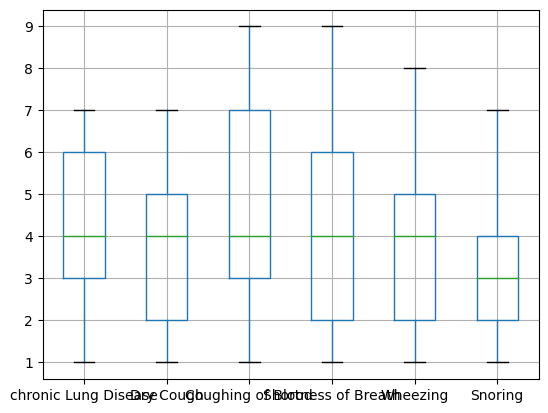

In [17]:
selected = data[['chronic Lung Disease', 'Dry Cough', 'Coughing of Blood', 'Shortness of Breath',	'Wheezing', 'Snoring']]
selected.boxplot()
plt.show()

In [18]:
print_outliers(selected)

Outliers for column chronic Lung Disease:
Empty DataFrame
Columns: [chronic Lung Disease, Dry Cough, Coughing of Blood, Shortness of Breath, Wheezing, Snoring]
Index: []
Outliers for column Dry Cough:
Empty DataFrame
Columns: [chronic Lung Disease, Dry Cough, Coughing of Blood, Shortness of Breath, Wheezing, Snoring]
Index: []
Outliers for column Coughing of Blood:
Empty DataFrame
Columns: [chronic Lung Disease, Dry Cough, Coughing of Blood, Shortness of Breath, Wheezing, Snoring]
Index: []
Outliers for column Shortness of Breath:
Empty DataFrame
Columns: [chronic Lung Disease, Dry Cough, Coughing of Blood, Shortness of Breath, Wheezing, Snoring]
Index: []
Outliers for column Wheezing:
Empty DataFrame
Columns: [chronic Lung Disease, Dry Cough, Coughing of Blood, Shortness of Breath, Wheezing, Snoring]
Index: []
Outliers for column Snoring:
Empty DataFrame
Columns: [chronic Lung Disease, Dry Cough, Coughing of Blood, Shortness of Breath, Wheezing, Snoring]
Index: []


### Selection 2: Lifestyle Related

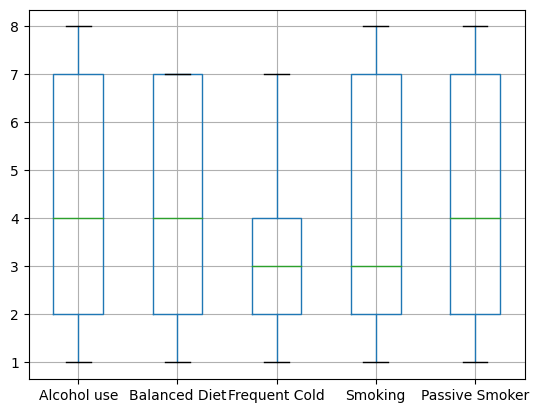

In [19]:
selected = data[['Alcohol use', 'Balanced Diet', 'Frequent Cold', 'Smoking', 'Passive Smoker']]
selected.boxplot()
plt.show()

In [20]:
print_outliers(selected)

Outliers for column Alcohol use:
Empty DataFrame
Columns: [Alcohol use, Balanced Diet, Frequent Cold, Smoking, Passive Smoker]
Index: []
Outliers for column Balanced Diet:
Empty DataFrame
Columns: [Alcohol use, Balanced Diet, Frequent Cold, Smoking, Passive Smoker]
Index: []
Outliers for column Frequent Cold:
Empty DataFrame
Columns: [Alcohol use, Balanced Diet, Frequent Cold, Smoking, Passive Smoker]
Index: []
Outliers for column Smoking:
Empty DataFrame
Columns: [Alcohol use, Balanced Diet, Frequent Cold, Smoking, Passive Smoker]
Index: []
Outliers for column Passive Smoker:
Empty DataFrame
Columns: [Alcohol use, Balanced Diet, Frequent Cold, Smoking, Passive Smoker]
Index: []


### Selection 3: Environmental Related

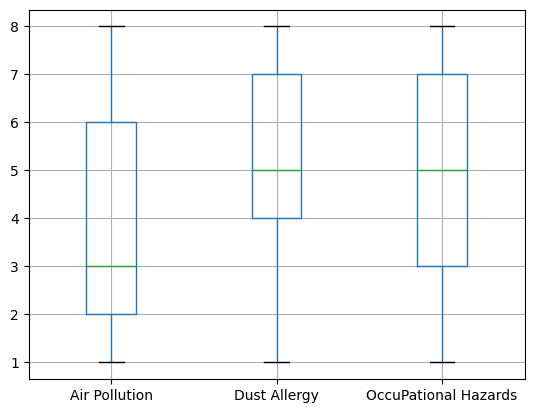

In [21]:
selected = data[['Air Pollution', 'Dust Allergy', 'OccuPational Hazards']]
selected.boxplot()
plt.show()

In [22]:
print_outliers(selected)

Outliers for column Air Pollution:
Empty DataFrame
Columns: [Air Pollution, Dust Allergy, OccuPational Hazards]
Index: []
Outliers for column Dust Allergy:
Empty DataFrame
Columns: [Air Pollution, Dust Allergy, OccuPational Hazards]
Index: []
Outliers for column OccuPational Hazards:
Empty DataFrame
Columns: [Air Pollution, Dust Allergy, OccuPational Hazards]
Index: []


### Selection 4: Physical/Body Related

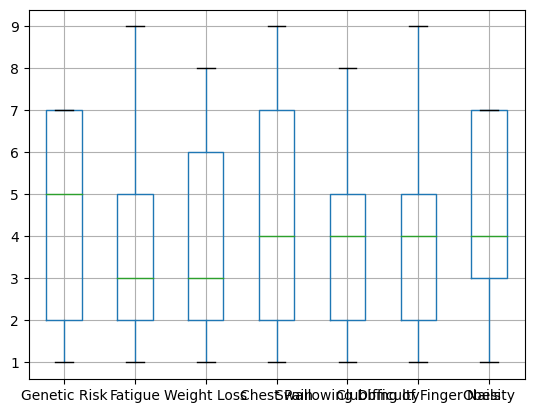

In [23]:
selected = data[['Genetic Risk', 'Fatigue',	'Weight Loss', 'Chest Pain', 'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Obesity']]
selected.boxplot()
plt.show()

In [24]:
print_outliers(selected)

Outliers for column Genetic Risk:
Empty DataFrame
Columns: [Genetic Risk, Fatigue, Weight Loss, Chest Pain, Swallowing Difficulty, Clubbing of Finger Nails, Obesity]
Index: []
Outliers for column Fatigue:
Empty DataFrame
Columns: [Genetic Risk, Fatigue, Weight Loss, Chest Pain, Swallowing Difficulty, Clubbing of Finger Nails, Obesity]
Index: []
Outliers for column Weight Loss:
Empty DataFrame
Columns: [Genetic Risk, Fatigue, Weight Loss, Chest Pain, Swallowing Difficulty, Clubbing of Finger Nails, Obesity]
Index: []
Outliers for column Chest Pain:
Empty DataFrame
Columns: [Genetic Risk, Fatigue, Weight Loss, Chest Pain, Swallowing Difficulty, Clubbing of Finger Nails, Obesity]
Index: []
Outliers for column Swallowing Difficulty:
Empty DataFrame
Columns: [Genetic Risk, Fatigue, Weight Loss, Chest Pain, Swallowing Difficulty, Clubbing of Finger Nails, Obesity]
Index: []
Outliers for column Clubbing of Finger Nails:
Empty DataFrame
Columns: [Genetic Risk, Fatigue, Weight Loss, Chest Pain,

## Visualization: Correlation

### Correlation Matrix Function

In [25]:
def corrmatrix(predictors):
  # Compute the correlation matrix
  corr = data[predictors].corr()

  # Create a heatmap to visualize the correlations
  sns.heatmap(corr, cmap='coolwarm', annot=True)

  # Add plot title and axis labels
  plt.title('Correlation Matrix')
  plt.xlabel('Predictor Variables')
  plt.ylabel('Response Variable')

  # Display the plot
  plt.show()

In [26]:
data

Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      33       1              2            4             5   
1      17       1              3            1             5   
2      35       1              4            5             6   
3      37       1              7            7             7   
4      46       1              6            8             7   
...   ...     ...            ...          ...           ...   
8755   23       1              3            2             4   
8756   73       1              5            6             6   
8757   52       1              6            8             7   
8758   32       2              1            6             7   
8759   14       1              2            4             5   

      OccuPational Hazards  Genetic Risk  chronic Lung Disease  Balanced Diet  \
0                        4             3                     2              2   
1                        3             4                     2              2   
2                        5             5                     4              6   
3                        7             6                     7              7   
4                        7             7                     6              7   
...                    ...           ...                   ...            ...   
8755                     2             3                     2              3   
8756                     5             6                     5              6   
8757                     7             7                     6              2   
8758                     8             7                     6              7   
8759                     6             5                     5              4   

      Obesity  ...  Fatigue  Weight Loss  Shortness of Breath  Wheezing  \
0           4  ...        3            4                    2         2   
1           2  ...        1            3                    7         8   
2           7  ...        8            7                    9         2   
3           7  ...        4            2                    3         1   
4           7  ...        3            2                    4         1   
...       ...  ...      ...          ...                  ...       ...   
8755        3  ...        4            5                    6         5   
8756        5  ...        4            3                    6         2   
8757        4  ...        2            7                    6         5   
8758        7  ...        3            2                    6         4   
8759        6  ...        5            3                    2         1   

      Swallowing Difficulty  Clubbing of Finger Nails  Frequent Cold  \
0                         3                         1              2   
1                         6                         2              1   
2                         1                         4              6   
3                         4                         5              6   
4                         4                         2              4   
...                     ...                       ...            ...   
8755                      5                         4              6   
8756                      1                         2              1   
8757                      1                         9              3   
8758                      2                         3              1   
8759                      4                         7              2   

      Dry Cough  Snoring  Level  
0             3        4      1  
1             7        2      2  
2             7        2      0  
3             7        5      0  
4             2        3      0  
...         ...      ...    ...  
8755          5        4      2  
8756          6        2      2  
8757          4        2      2  
8758          2        1      2  
8759          1        6      2  

[17392 rows x 24 columns]

### Selection 1: Coughing/Breathing

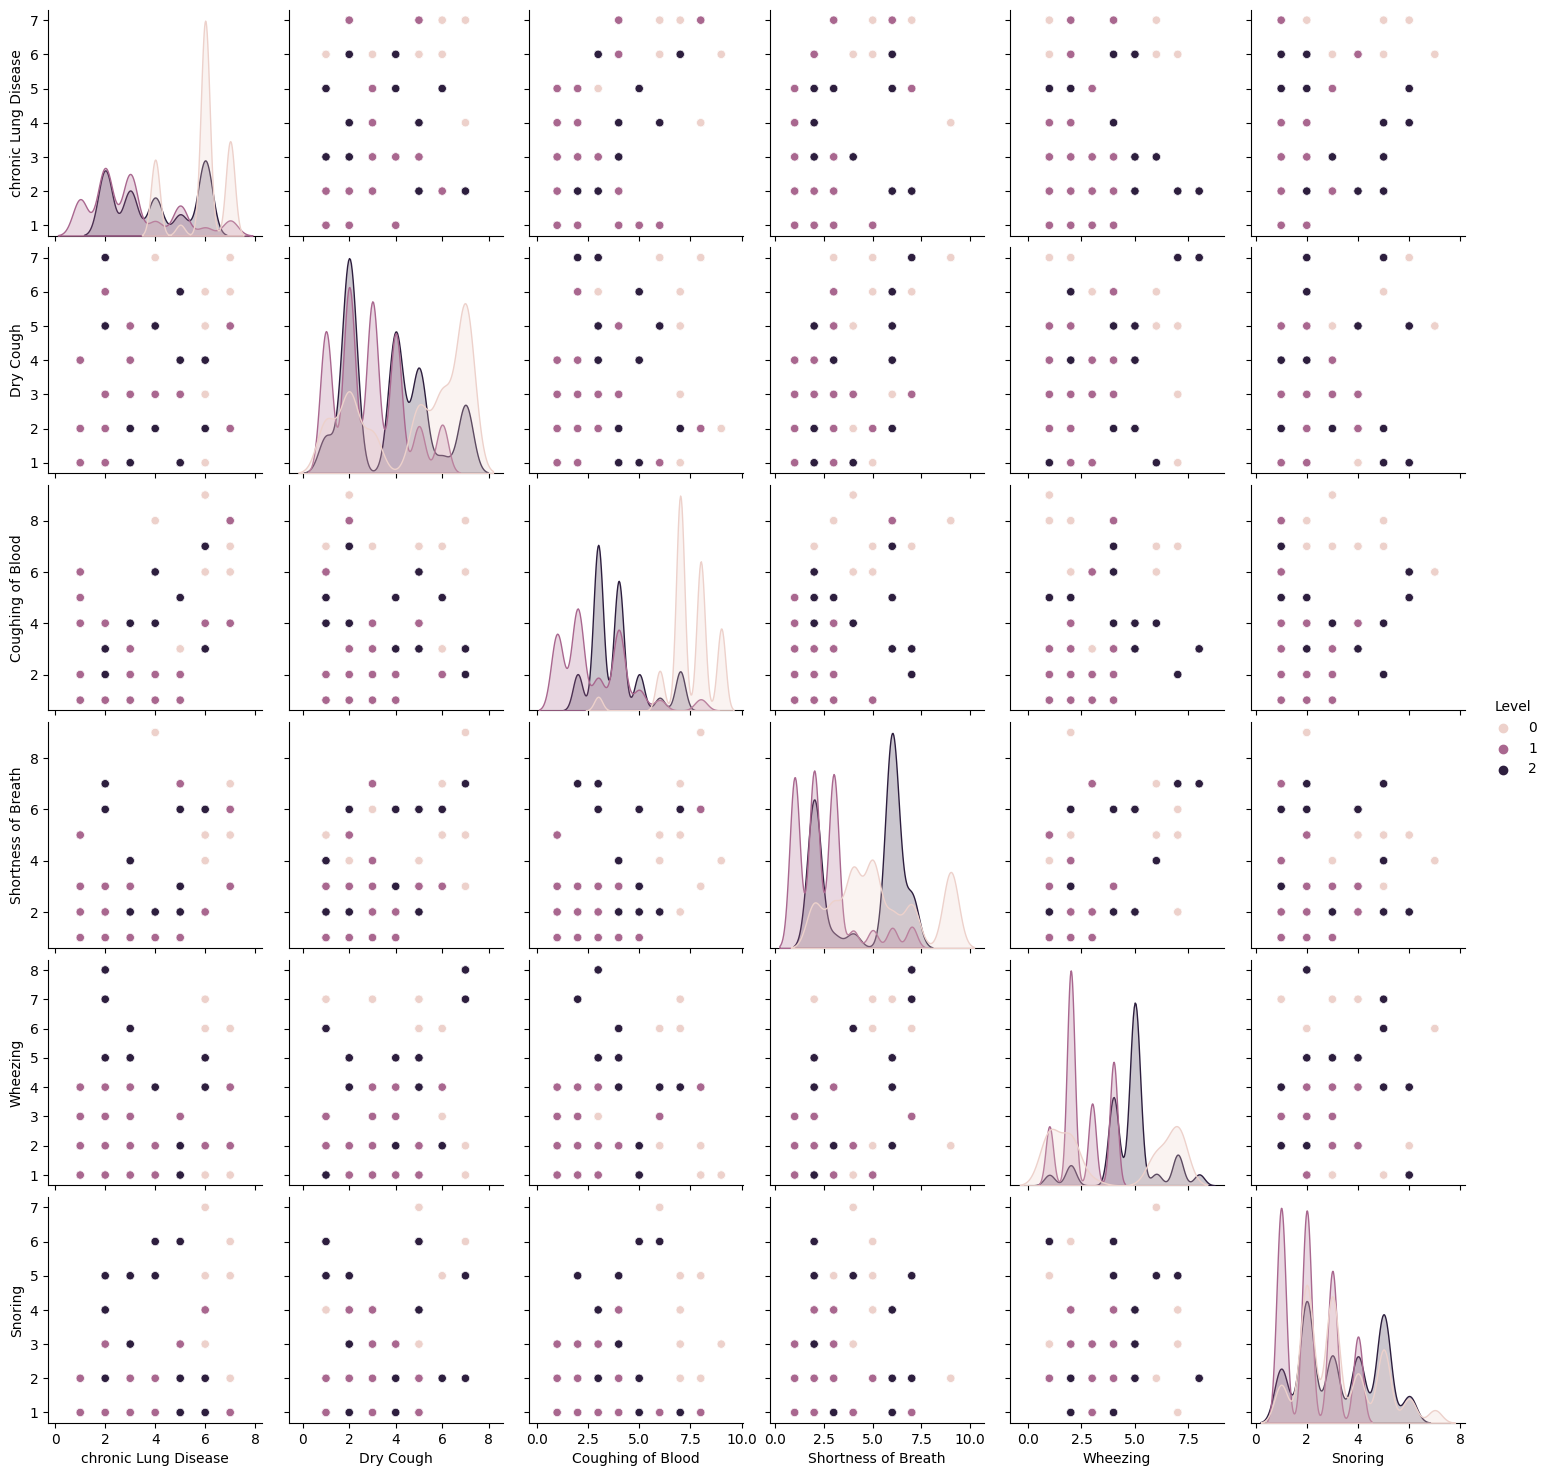

In [27]:
# Pairplot (for exploring multiple variables)
sns.pairplot(data, vars=['chronic Lung Disease',	'Dry Cough', 'Coughing of Blood', 'Shortness of Breath',	'Wheezing', 'Snoring'], hue='Level')
plt.show()

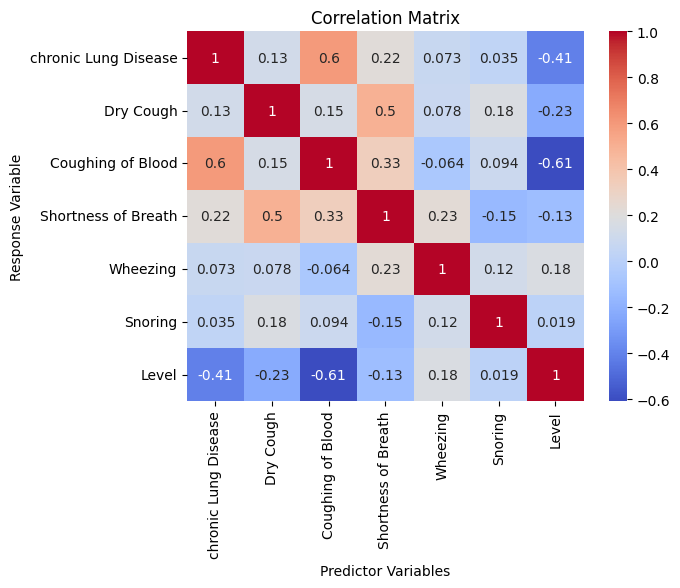

In [28]:
predictors = ['chronic Lung Disease',	'Dry Cough', 'Coughing of Blood', 'Shortness of Breath',	'Wheezing', 'Snoring', 'Level']
corrmatrix(predictors)

With a cutoff of 0.4, **Chronic Lung Disease** (-0.42) and **Coughing Blood** (-0.61) seem to be the most negatively correlated variables, in relation to the patient's cancer level

### Selection 2: Lifestyle

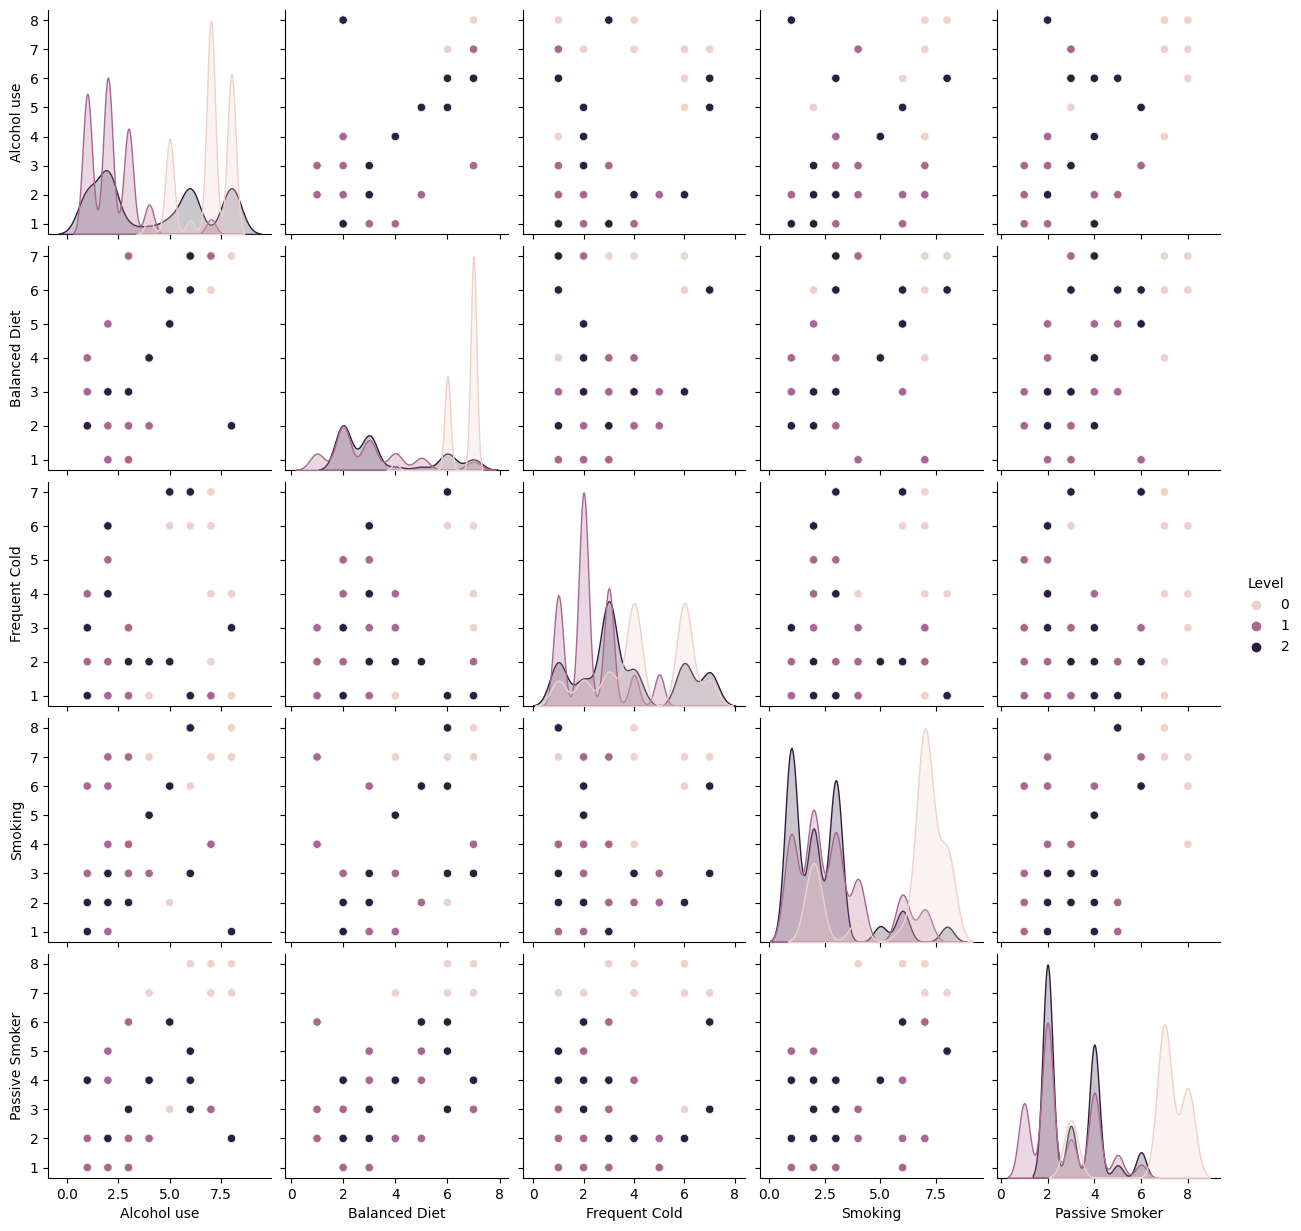

In [29]:
# Pairplot (for exploring multiple variables)
sns.pairplot(data, vars=['Alcohol use', 'Balanced Diet', 'Frequent Cold', 'Smoking', 'Passive Smoker'], hue='Level')
plt.show()

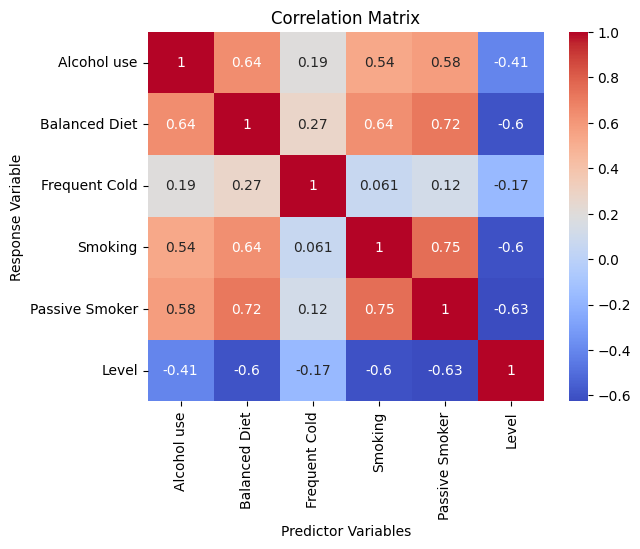

In [30]:
predictors = ['Alcohol use', 'Balanced Diet', 'Frequent Cold', 'Smoking', 'Passive Smoker', 'Level']
corrmatrix(predictors)

With a cutoff of 0.4, most of the variables seem to be correlated with the cancer level target variable, namely; **Alcohol Use** (-0.42), **Balanced Diet** (-0.6), **Smoking** (-0.6), and **Passive Smoking** (-0.63).

### Selection 3: Environmental

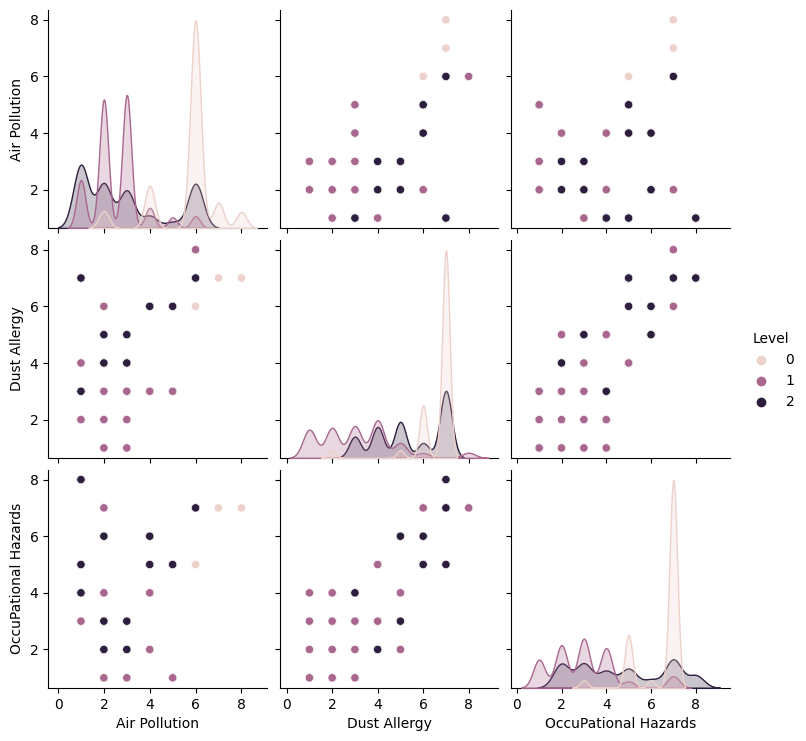

In [31]:
# Pairplot (for exploring multiple variables)
sns.pairplot(data, vars=['Air Pollution', 'Dust Allergy', 'OccuPational Hazards'], hue='Level')
plt.show()

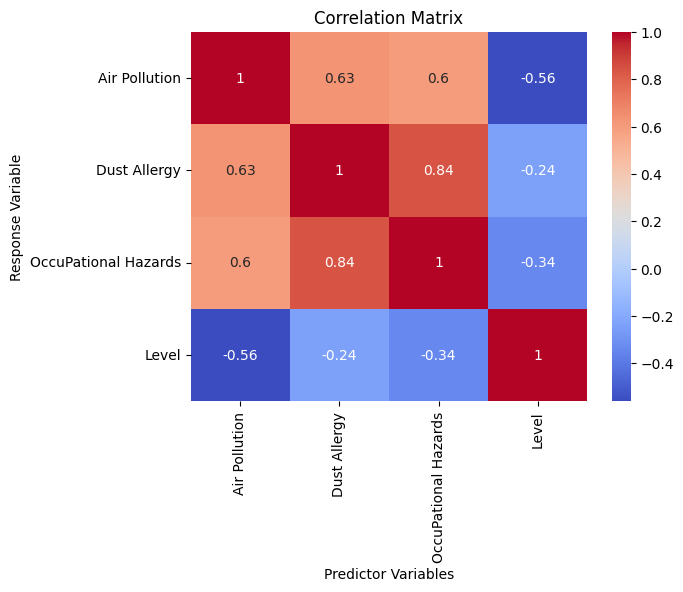

In [32]:
predictors = ['Air Pollution', 'Dust Allergy', 'OccuPational Hazards', 'Level']
corrmatrix(predictors)

With a cutoff of 0.4, the seemingly somewhat negatively correlated variable is **Air Pollution** at -0.57

### Selection 4: Physical/Body Related

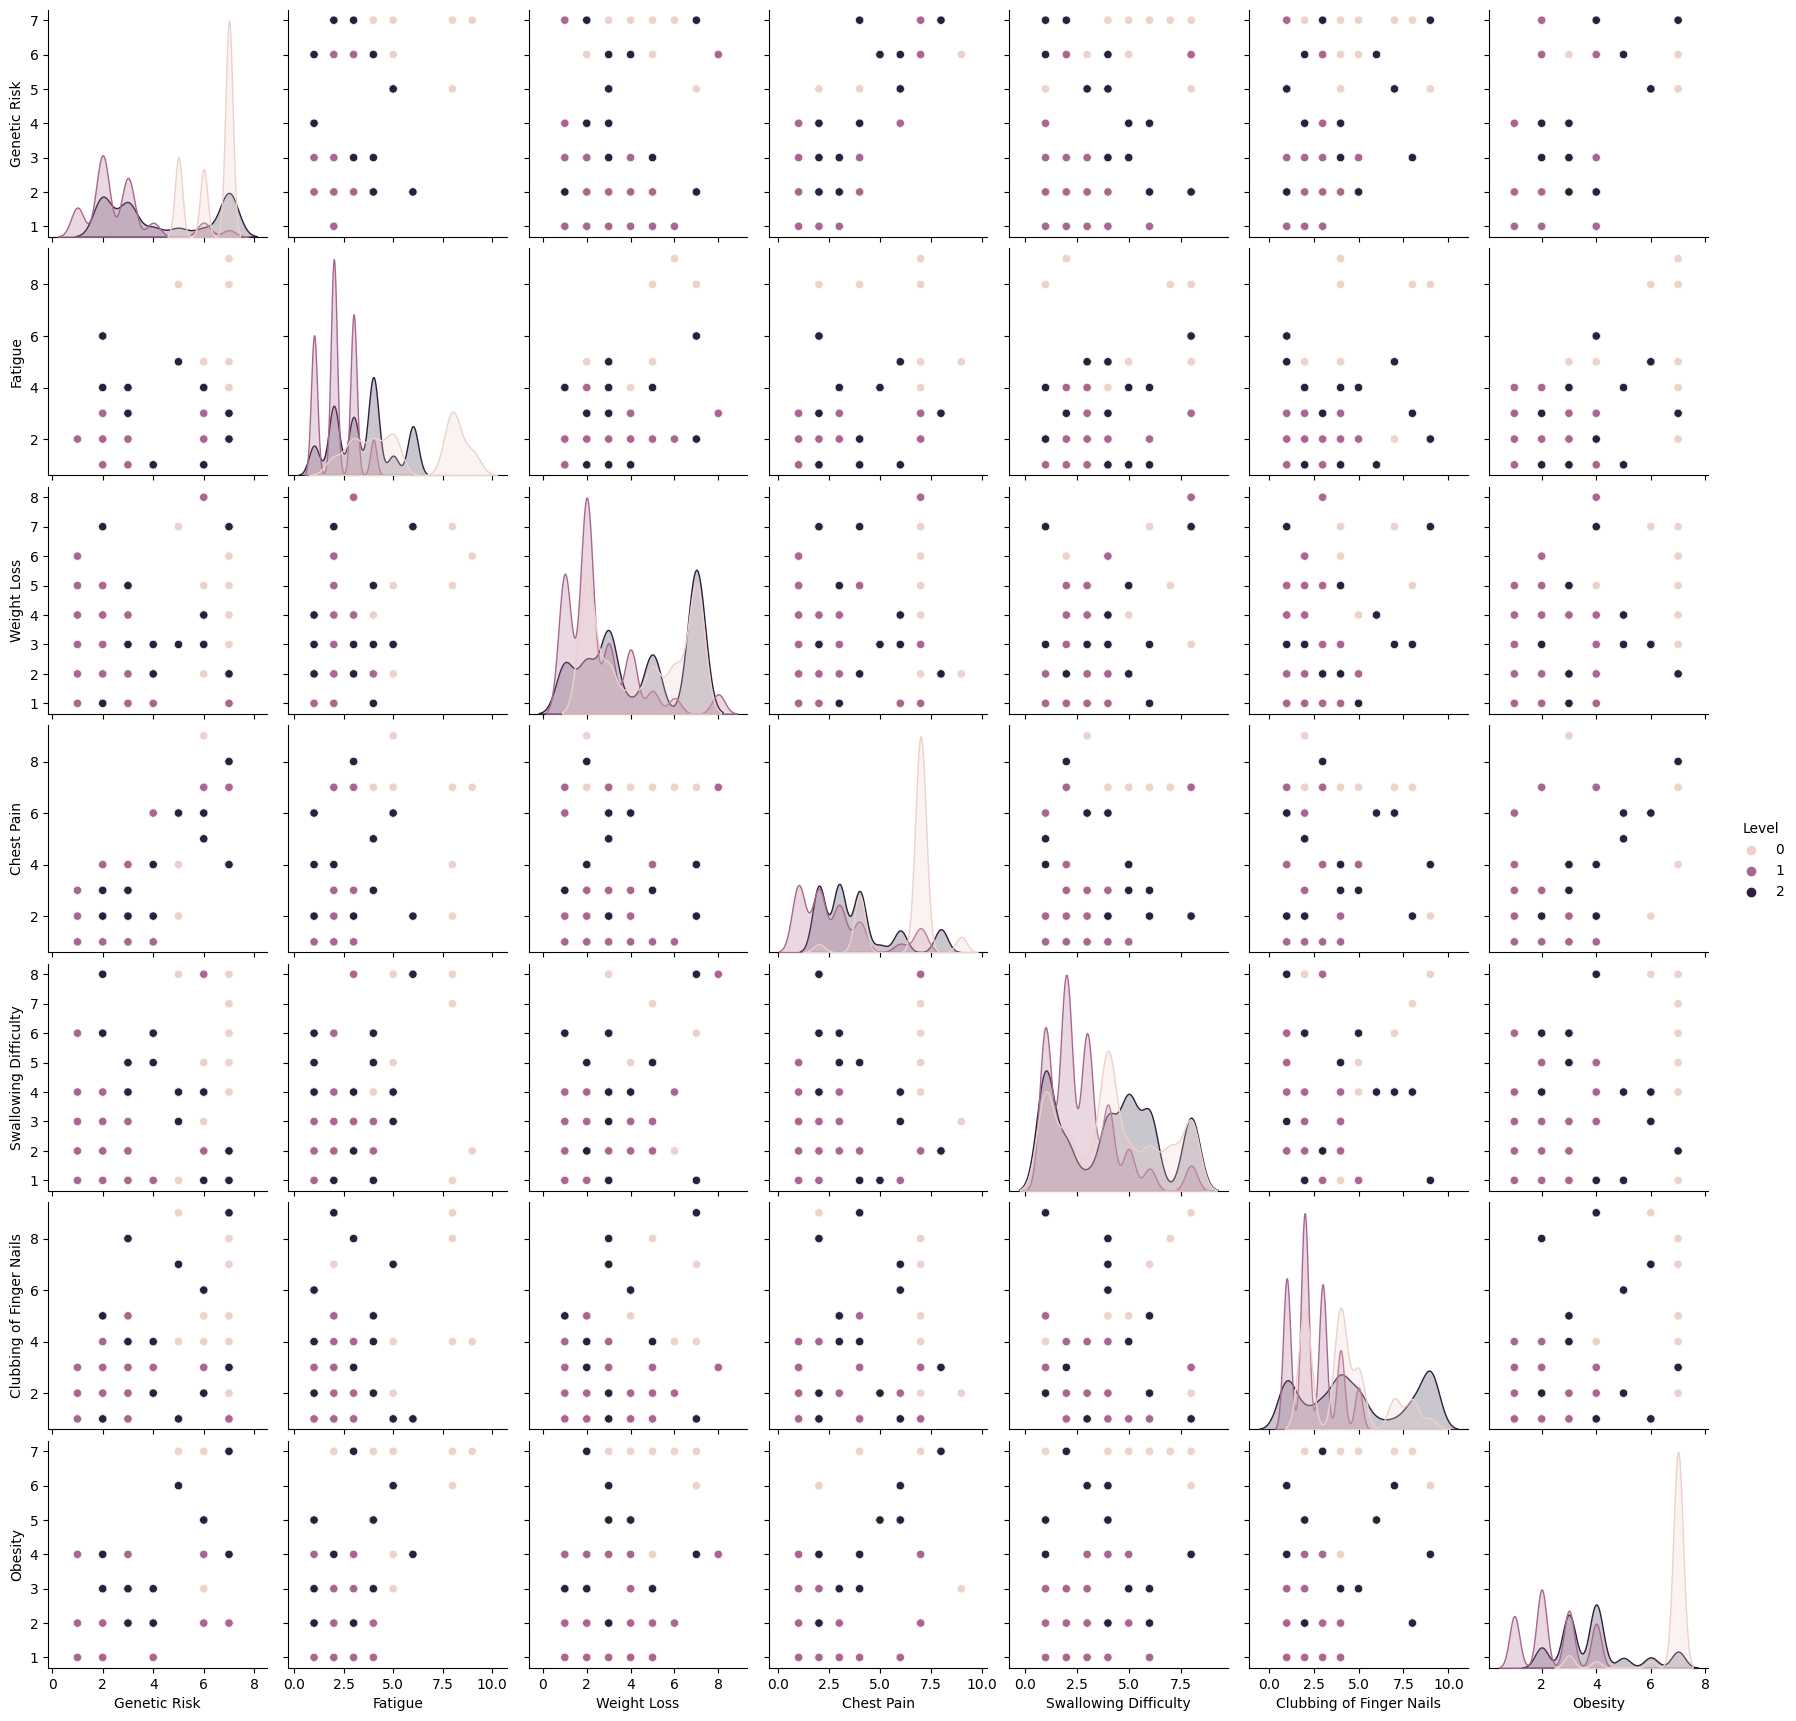

In [33]:
# Pairplot (for exploring multiple variables)
sns.pairplot(data, vars=['Genetic Risk', 'Fatigue',	'Weight Loss', 'Chest Pain', 'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Obesity'], hue='Level')
plt.show()

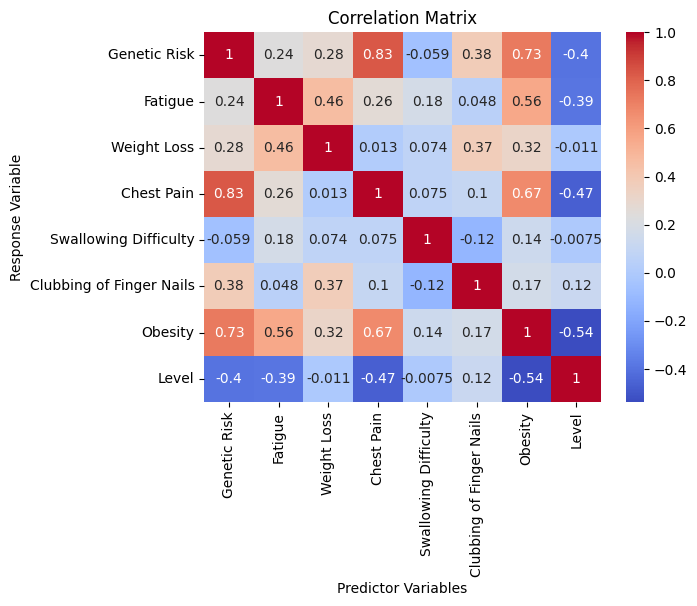

In [34]:
predictors = ['Genetic Risk', 'Fatigue',	'Weight Loss', 'Chest Pain', 'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Obesity', 'Level']
corrmatrix(predictors)

With a cutoff of 0.4, the most correlated (negatively) variables appear to be **Genetic Risk** (-0.4), **Chest Pain** (-0.47) and **Obesity** (-0.54)

# **Data Splitting**

In [35]:
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# **Data Normalization**

We will use the Standard Scaler to normailze our data. This process of normalization transforms the feature values to have zero mean and unit variance. It helps to center the feature distribution around zero and brings all the features to a similar scale. Normalizing the features prevents any single feature from dominating the learning process due to its larger values.

In [36]:
scaler = StandardScaler()
scaler.fit_transform(X)

# Transform the training, validation, and test data
data_X_train = scaler.transform(X_train_)
data_X_val = scaler.transform(X_val_)
data_X_test = scaler.transform(X_test_)

# **Feature Selection**

We perform feature selection after splitting the data to help prevent information leakage and ensure that the feature selection process is based only on the data that the model will be trained on.

### Mutual Information

By measuring the mutual information between each feature and the target variable, we can rank the features based on their importance or relevance to the target. Features with higher mutual information are considered more informative for predicting the target variable and can be selected for model training. This helps in reducing dimensionality and focusing on the most relevant features, which can improve model performance and reduce overfitting.

We will select an equal number of 10 features.

In [37]:
data_X = data.drop(['Level'], axis=1)
data_y = data['Level']

In [38]:
# Calculate the mutual information between each feature and the target variable
mi = mutual_info_classif(data_X, data_y)

# Select the k best features based on mutual information
k = 10
selector = SelectKBest(mutual_info_classif, k=k)

X_best = selector.fit_transform(X_train_, y_train_)

# Get the indices of the selected features
selected_features = selector.get_support(indices=True)

# Get the names of the selected features
feature_names_mi = X_train_.columns[selected_features]

print(feature_names_mi)

Index(['Alcohol use', 'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk',
       'Balanced Diet', 'Obesity', 'Passive Smoker', 'Chest Pain',
       'Coughing of Blood', 'Wheezing'],
      dtype='object')


In [39]:
data_X_train_mi = selector.fit_transform(X_train_, y_train_)
data_X_val_mi = selector.fit_transform(X_val_, y_val_)
data_X_test_mi = selector.fit_transform(X_test_, y_test_)

### Manual Feature Selection

**Feature Selection**: We will use the highly correlated variables stated above, to train our model; instead of using all 23 features.

From our correlation analysis, the following features are the ten we will pick for our machine learning processes, especially when using neural networks.

In [40]:
feature_names_selected = ['chronic Lung Disease',	'Coughing of Blood', 'Alcohol use', 'Balanced Diet', 'Smoking', 'Passive Smoker', 'Air Pollution', 'Genetic Risk', 'Chest Pain', 'Obesity']

In [41]:
data_X_train_selected = X_train_[feature_names_selected]
data_X_val_selected = X_val_[feature_names_selected]
data_X_test_selected = X_test_[feature_names_selected]

# **Logistic Regression**

## Data Specification

In [42]:
y_train = y_train_
y_test = y_test_
y_val = y_val_

In [43]:
X_train = data_X_train
X_val = data_X_val
X_test = data_X_test

In [44]:
X_train_mi = data_X_train_mi
X_val_mi = data_X_val_mi
X_test_mi = data_X_test_mi

In [45]:
X_train_selected = data_X_train_selected
X_val_selected = data_X_val_selected
X_test_selected = data_X_test_selected

# *Model LR-A: Standard*

In [46]:
max_epochs = 200

## **Model LR-A-1: Basic**

### Model: Basic

In [47]:
reg = LogisticRegression(penalty='l2', C=0.8, max_iter=max_epochs)
model = Pipeline([('scaler', StandardScaler()), ('reg', reg)])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', LogisticRegression(C=0.8, max_iter=200))])

### Evaluation: Training

In [48]:
y_pred = model.predict(X_val)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       1.00      1.00      1.00      1164
           2       1.00      1.00      1.00      1181

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



### Evaluation: Testing

In [49]:
y_pred = model.predict(X_test)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1152
           2       1.00      1.00      1.00      1184

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



### Evaluation: Coefficients

In [50]:
# Interpretation
coefs = model.named_steps['reg'].coef_
intercept = model.named_steps['reg'].intercept_

# Analyze the coefficients to understand the impact of each feature on the predicted cancer level
for i in range(coefs.shape[0]):
    print(f'---- Coefficient value (class {i}) ----')
    sorted_features = sorted(zip(feature_names, coefs[i]), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f'{feature}: {coef}')
    print('')

print(f'\nIntercept: {intercept}')

---- Coefficient value (class 0) ----
Swallowing Difficulty: 2.1710729773616677
Coughing of Blood: 2.0657717144609933
Passive Smoker: 2.0574633533500135
Fatigue: 2.031033114293315
Alcohol use: 1.376763445974873
Obesity: 1.3391453404474132
Air Pollution: 1.2953534037177206
Shortness of Breath: 1.207039626825726
chronic Lung Disease: 1.1530750939190144
Clubbing of Finger Nails: 1.1355193320492931
Frequent Cold: 1.0053616622078054
Balanced Diet: 0.9320786868899003
Weight Loss: 0.8945273098295273
Dry Cough: 0.8501622619092216
Snoring: 0.7000129073506857
Genetic Risk: 0.6895170601062459
Wheezing: 0.4704840477720664
Smoking: 0.30924763392676546
Dust Allergy: -0.26322729390320243
Chest Pain: 0.17808831339830414
Gender: 0.10848040814810539
OccuPational Hazards: 0.05964169024530745
Age: -0.05113758489703307

---- Coefficient value (class 1) ----
Obesity: -2.7097283351675596
Passive Smoker: -2.419711128799453
Wheezing: -2.3665734911939724
Coughing of Blood: -2.1529710935913435
Swallowing Difficu

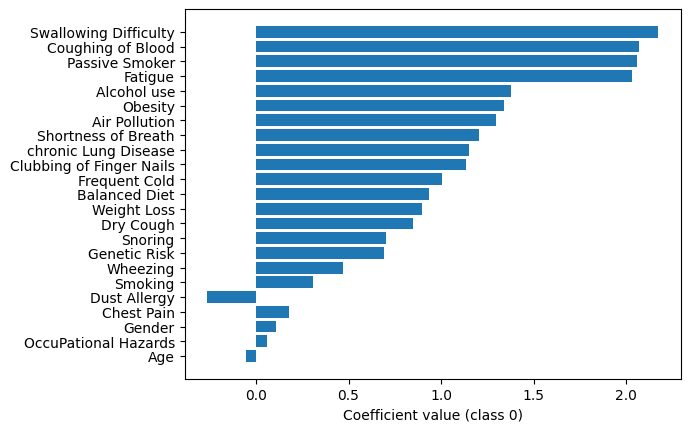

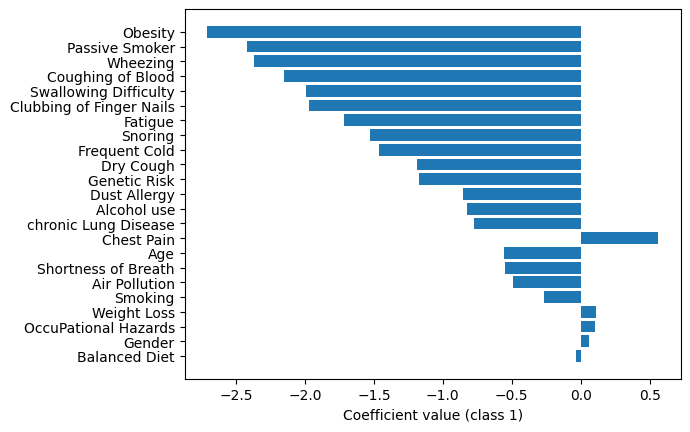

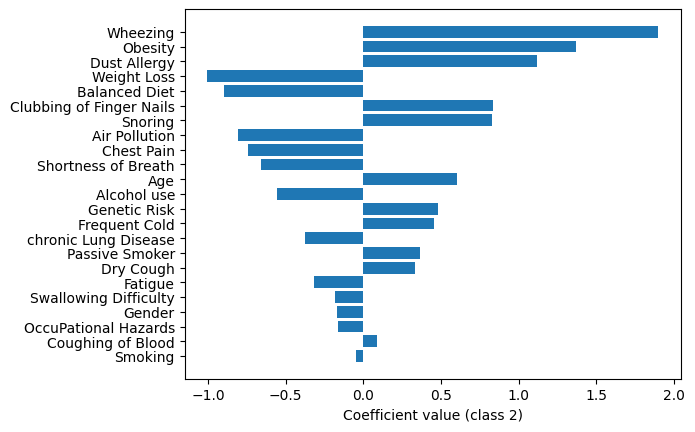

In [51]:
for i in range(coefs.shape[0]):
    plt.figure()
    sorted_features = sorted(zip(feature_names, coefs[i]), key=lambda x: abs(x[1]), reverse=False)
    plt.barh(range(coefs.shape[1]), [x[1] for x in sorted_features])
    plt.yticks(range(coefs.shape[1]), [x[0] for x in sorted_features])
    plt.xlabel(f'Coefficient value (class {i})')
    plt.show()

## **Model LR-A-2: Mutual Information**

### Model: Mutual Information

In [52]:
reg = LogisticRegression(penalty='l2', C=0.8, max_iter=max_epochs)
model_mi = Pipeline([('scaler', StandardScaler()), ('reg', reg)])
model_mi.fit(X_train_mi, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', LogisticRegression(C=0.8, max_iter=200))])

### Evaluation: Training (Mutual Information)

In [53]:
y_pred = model_mi.predict(X_val_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.6271917217591262
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1134
           1       0.54      0.66      0.59      1164
           2       0.57      0.44      0.50      1181

    accuracy                           0.63      3479
   macro avg       0.63      0.63      0.63      3479
weighted avg       0.63      0.63      0.62      3479



### Evaluation: Testing (Mutual Information)

In [54]:
y_pred = model_mi.predict(X_test_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8729519977004886
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1143
           1       0.79      0.97      0.87      1152
           2       0.93      0.73      0.82      1184

    accuracy                           0.87      3479
   macro avg       0.88      0.87      0.87      3479
weighted avg       0.88      0.87      0.87      3479



### Evaluation: Coefficients (Mutual Information)

In [55]:
coefs = model_mi.named_steps['reg'].coef_
intercept = model_mi.named_steps['reg'].intercept_

for i in range(coefs.shape[0]):
    print(f'---- Coefficient value (class {i}) ----')
    sorted_features = sorted(zip(feature_names_mi, coefs[i]), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f'{feature}: {coef}')
    print('')

print(f'\nIntercept: {intercept}')

---- Coefficient value (class 0) ----
Passive Smoker: 9.151510727331791
Balanced Diet: 7.042586472298945
Genetic Risk: -6.635556718144193
Chest Pain: 5.413904931550526
Alcohol use: 4.152463197228395
OccuPational Hazards: -3.78272842386558
Coughing of Blood: 3.6520599459840075
Wheezing: 1.8111012675801064
Dust Allergy: -1.5509544460670392
Obesity: -0.786833335507479

---- Coefficient value (class 1) ----
Passive Smoker: -10.708317861790983
Wheezing: -6.838300456382117
Balanced Diet: -6.274922750534423
Genetic Risk: 4.485364872253288
Chest Pain: -4.209395747465337
Alcohol use: -3.440164178945789
OccuPational Hazards: 3.4133752121826793
Obesity: 3.194765848341265
Coughing of Blood: -2.853347514302272
Dust Allergy: 0.20255490291015354

---- Coefficient value (class 2) ----
Wheezing: 5.027199188801965
Obesity: -2.407932512833712
Genetic Risk: 2.1501918458909484
Passive Smoker: 1.5568071344592236
Dust Allergy: 1.3483995431569205
Chest Pain: -1.2045091840850923
Coughing of Blood: -0.798712431

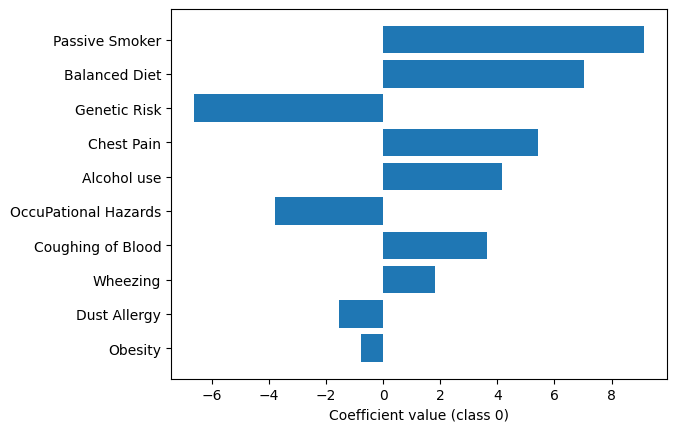

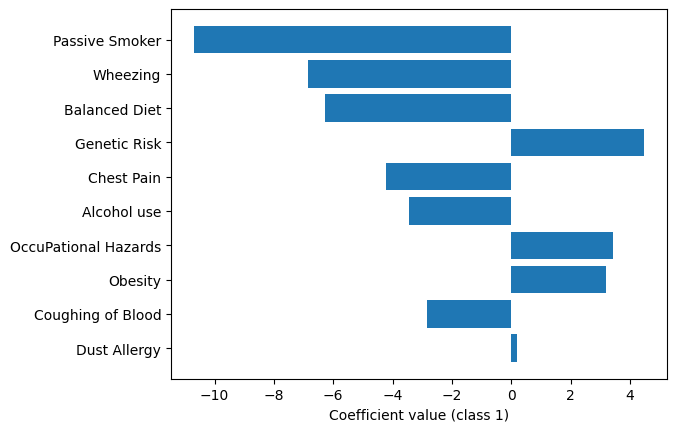

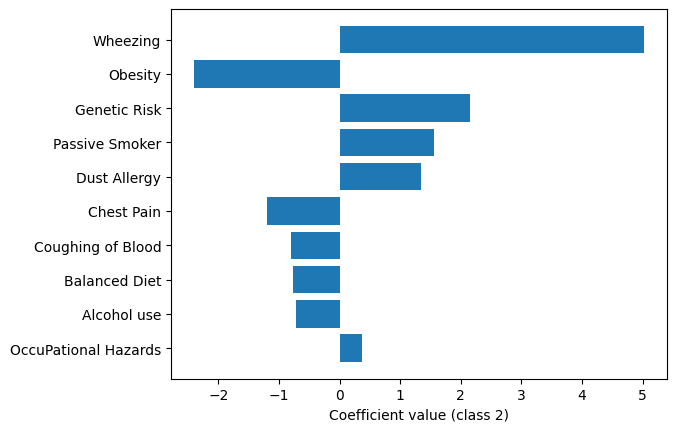

In [56]:
for i in range(coefs.shape[0]):
    plt.figure()
    sorted_features = sorted(zip(feature_names_mi, coefs[i]), key=lambda x: abs(x[1]), reverse=False)
    plt.barh(range(coefs.shape[1]), [x[1] for x in sorted_features])
    plt.yticks(range(coefs.shape[1]), [x[0] for x in sorted_features])
    plt.xlabel(f'Coefficient value (class {i})')
    plt.show()

## **Model LR-A-3: Manual Feature Selection**


### Model: Manual Feature Selection

In [57]:
reg = LogisticRegression(penalty='l2', C=0.8, max_iter=max_epochs)
model_selected = Pipeline([('scaler', StandardScaler()), ('reg', reg)])
model_selected.fit(X_train_selected, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', LogisticRegression(C=0.8, max_iter=200))])

### Evaluation: Training (Manual Feature Selection)

In [58]:
y_pred = model_selected.predict(X_val_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.8329979879275654
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.72      0.83      0.77      1164
           2       0.80      0.68      0.73      1181

    accuracy                           0.83      3479
   macro avg       0.84      0.84      0.83      3479
weighted avg       0.84      0.83      0.83      3479



### Evaluation: Testing (Manual Feature Selection)

In [59]:
y_pred = model_selected.predict(X_test_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8258120149468238
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       0.70      0.83      0.76      1152
           2       0.80      0.65      0.72      1184

    accuracy                           0.83      3479
   macro avg       0.83      0.83      0.83      3479
weighted avg       0.83      0.83      0.82      3479



### Evaluation: Coefficients (Manual Feature Selection)

In [60]:
# Interpretation
coefs = model_selected.named_steps['reg'].coef_
intercept = model_selected.named_steps['reg'].intercept_

for i in range(coefs.shape[0]):
    print(f'---- Coefficient value (class {i}) ----')
    sorted_features = sorted(zip(feature_names_selected, coefs[i]), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f'{feature}: {coef}')
    print('')

print(f'\nIntercept: {intercept}')

---- Coefficient value (class 0) ----
Passive Smoker: 5.876027333539739
chronic Lung Disease: 4.778986627456279
Alcohol use: 4.667424660090879
Obesity: 4.64275689423558
Chest Pain: -4.419627259325455
Coughing of Blood: 3.9471794586454436
Genetic Risk: -2.2111172786065483
Smoking: -2.080410993248092
Air Pollution: 1.5198859291240743
Balanced Diet: 0.9293382596240134

---- Coefficient value (class 1) ----
Obesity: -3.5168556844784664
Passive Smoker: -3.262671432130595
Chest Pain: 2.7048458401729154
Coughing of Blood: -2.6629719905824007
Alcohol use: -2.631044067009813
Smoking: 2.20043994088692
chronic Lung Disease: -2.1954637377939803
Balanced Diet: -0.8304262607260773
Air Pollution: 0.0950047468257762
Genetic Risk: 0.06211421644483334

---- Coefficient value (class 2) ----
Passive Smoker: -2.613355901409057
chronic Lung Disease: -2.583522889662285
Genetic Risk: 2.1490030621617713
Alcohol use: -2.036380593081065
Chest Pain: 1.714781419152601
Air Pollution: -1.614890675949801
Coughing of 

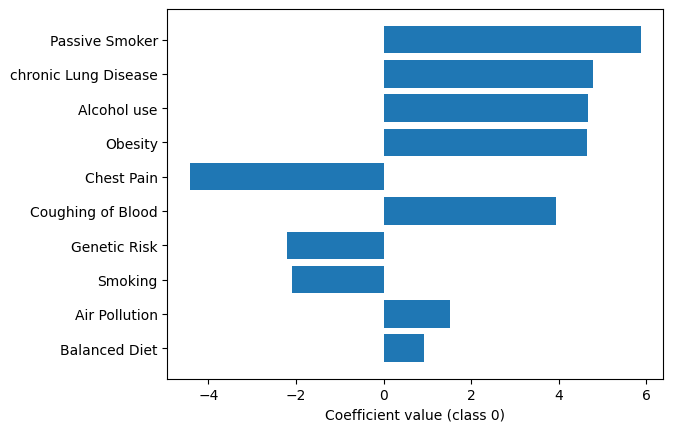

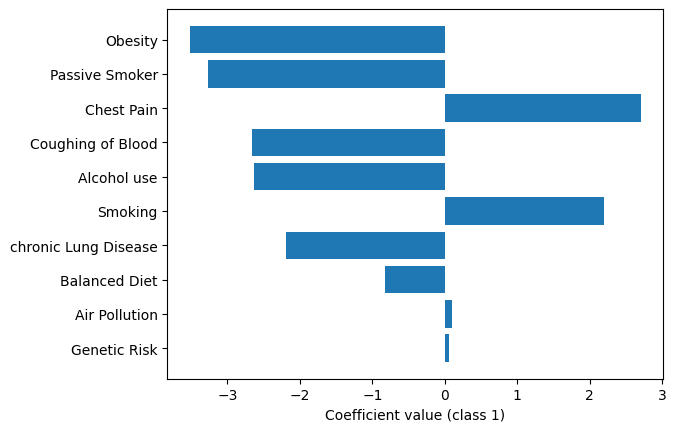

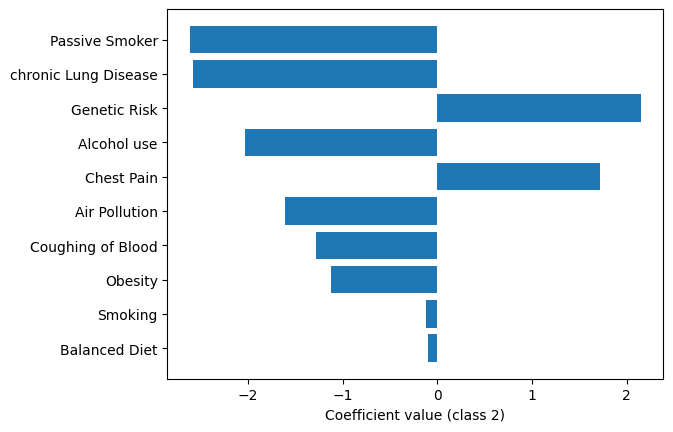

In [61]:
for i in range(coefs.shape[0]):
    plt.figure()
    sorted_features = sorted(zip(feature_names_selected, coefs[i]), key=lambda x: abs(x[1]), reverse=False)
    plt.barh(range(coefs.shape[1]), [x[1] for x in sorted_features])
    plt.yticks(range(coefs.shape[1]), [x[0] for x in sorted_features])
    plt.xlabel(f'Coefficient value (class {i})')
    plt.show()

# *Model LR-B: SGDClassifier*

The following code creates a pipeline with an SGDClassifier model that uses the log loss function to perform logistic regression. The penalty parameter is set to 'elasticnet' to use Elastic Net regularization, and the l1_ratio parameter is set to 0.3 to control the relative importance of the L1 and L2 penalty terms.

The l1_ratio parameter controls the trade-off between the L1 and L2 penalty terms. A value of 0 corresponds to L2 regularization only, while a value of 1 corresponds to L1 regularization only.

## **Model LR-B-1: Basic**

### Model: Basic

In [62]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SGDClassifier(loss='log_loss', penalty='elasticnet', l1_ratio=0.15))
])

### Training

In [63]:
n_epochs = 120

In [64]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(n_epochs):
    model.fit(X_train, y_train)
    # loss
    y_pred_val = model.predict_proba(X_val)
    y_pred_test = model.predict_proba(X_test)
    train_loss.append(log_loss(y_val, y_pred_val))
    val_loss.append(log_loss(y_test, y_pred_test))
    # accuracy
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    train_acc.append(accuracy_score(y_val, y_pred_val))
    val_acc.append(accuracy_score(y_test, y_pred_test))


### Evaluation: Training

In [65]:
y_pred = model.predict(X_val)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       1.00      1.00      1.00      1164
           2       1.00      1.00      1.00      1181

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



### Evaluation: Testing

In [66]:
y_pred = model.predict(X_test)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1152
           2       1.00      1.00      1.00      1184

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



### Evaluation: Coefficients

In [67]:
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_
feature_names = X.columns

for i in range(coefs.shape[0]):
    print(f'---- Coefficient value (class {i}) ----')
    sorted_features = sorted(zip(feature_names, coefs[i]), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f'{feature}: {coef}')
    print('')

print(f'\nIntercept: {intercept}')

---- Coefficient value (class 0) ----
OccuPational Hazards: 5.876027333539739
Age: 4.778986627456279
Air Pollution: 4.667424660090879
Obesity: 4.64275689423558
Balanced Diet: -4.419627259325455
Gender: 3.9471794586454436
chronic Lung Disease: -2.2111172786065483
Dust Allergy: -2.080410993248092
Genetic Risk: 1.5198859291240743
Alcohol use: 0.9293382596240134

---- Coefficient value (class 1) ----
Obesity: -3.5168556844784664
OccuPational Hazards: -3.262671432130595
Balanced Diet: 2.7048458401729154
Gender: -2.6629719905824007
Air Pollution: -2.631044067009813
Dust Allergy: 2.20043994088692
Age: -2.1954637377939803
Alcohol use: -0.8304262607260773
Genetic Risk: 0.0950047468257762
chronic Lung Disease: 0.06211421644483334

---- Coefficient value (class 2) ----
OccuPational Hazards: -2.613355901409057
Age: -2.583522889662285
chronic Lung Disease: 2.1490030621617713
Air Pollution: -2.036380593081065
Balanced Diet: 1.714781419152601
Genetic Risk: -1.614890675949801
Gender: -1.28420746806305

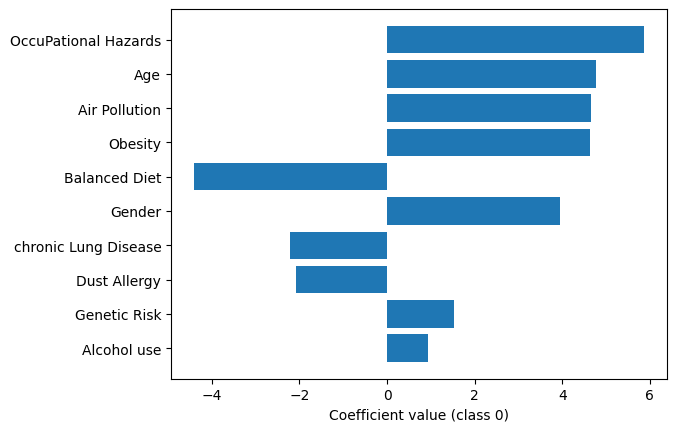

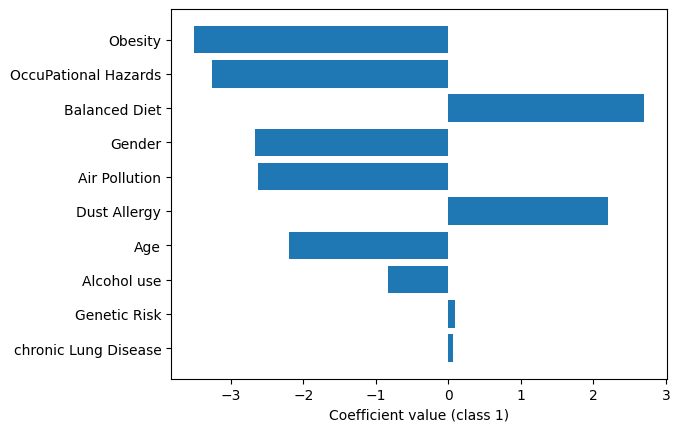

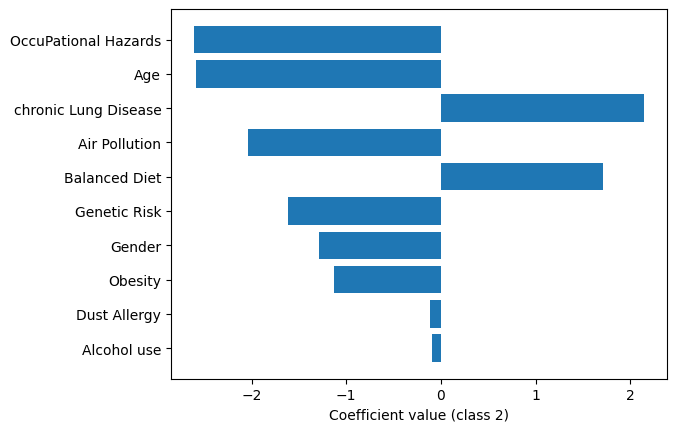

In [68]:
for i in range(coefs.shape[0]):
    plt.figure()
    sorted_features = sorted(zip(feature_names, coefs[i]), key=lambda x: abs(x[1]), reverse=False)
    plt.barh(range(coefs.shape[1]), [x[1] for x in sorted_features])
    plt.yticks(range(coefs.shape[1]), [x[0] for x in sorted_features])
    plt.xlabel(f'Coefficient value (class {i})')
    plt.show()

## **Model LR-B-2: Mutual Information**

### Model: Mutual Information

In [69]:
model_mi = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SGDClassifier(loss='log_loss', penalty='elasticnet', l1_ratio=0.15))
])

### Training

In [70]:
n_epochs = 120

In [71]:
mi_train_loss, mi_val_loss, mi_train_acc, mi_val_acc = [], [], [], []

for epoch in range(n_epochs):
    model_mi.fit(X_train_mi, y_train)
    # loss
    y_pred_val = model_mi.predict_proba(X_val_mi)
    y_pred_test = model_mi.predict_proba(X_test_mi)
    mi_train_loss.append(log_loss(y_val, y_pred_val))
    mi_val_loss.append(log_loss(y_test, y_pred_test))
    # accuracy
    y_pred_val = model_mi.predict(X_val_mi)
    y_pred_test = model_mi.predict(X_test_mi)
    mi_train_acc.append(accuracy_score(y_val, y_pred_val))
    mi_val_acc.append(accuracy_score(y_test, y_pred_test))


### Evaluation: Training (Mutual Information)



In [72]:
y_pred = model_mi.predict(X_val_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.6498993963782697
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1134
           1       0.56      0.73      0.64      1164
           2       0.60      0.44      0.51      1181

    accuracy                           0.65      3479
   macro avg       0.66      0.65      0.65      3479
weighted avg       0.66      0.65      0.65      3479



### Evaluation: Testing (Mutual Information)

In [73]:
y_pred = model_mi.predict(X_test_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8623167576889911
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1143
           1       0.77      0.97      0.86      1152
           2       0.96      0.68      0.79      1184

    accuracy                           0.86      3479
   macro avg       0.88      0.86      0.86      3479
weighted avg       0.88      0.86      0.86      3479



### Evaluation: Coefficients (Mutual Information)

In [74]:
coefficients = model_mi.named_steps['regressor'].coef_
intercept = model_mi.named_steps['regressor'].intercept_

for i in range(coefs.shape[0]):
    print(f'---- Coefficient value (class {i}) ----')
    sorted_features = sorted(zip(feature_names_mi, coefs[i]), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f'{feature}: {coef}')
    print('')

print(f'\nIntercept: {intercept}')

---- Coefficient value (class 0) ----
Obesity: 5.876027333539739
Alcohol use: 4.778986627456279
OccuPational Hazards: 4.667424660090879
Wheezing: 4.64275689423558
Coughing of Blood: -4.419627259325455
Dust Allergy: 3.9471794586454436
Chest Pain: -2.2111172786065483
Balanced Diet: -2.080410993248092
Passive Smoker: 1.5198859291240743
Genetic Risk: 0.9293382596240134

---- Coefficient value (class 1) ----
Wheezing: -3.5168556844784664
Obesity: -3.262671432130595
Coughing of Blood: 2.7048458401729154
Dust Allergy: -2.6629719905824007
OccuPational Hazards: -2.631044067009813
Balanced Diet: 2.20043994088692
Alcohol use: -2.1954637377939803
Genetic Risk: -0.8304262607260773
Passive Smoker: 0.0950047468257762
Chest Pain: 0.06211421644483334

---- Coefficient value (class 2) ----
Obesity: -2.613355901409057
Alcohol use: -2.583522889662285
Chest Pain: 2.1490030621617713
OccuPational Hazards: -2.036380593081065
Coughing of Blood: 1.714781419152601
Passive Smoker: -1.614890675949801
Dust Allergy:

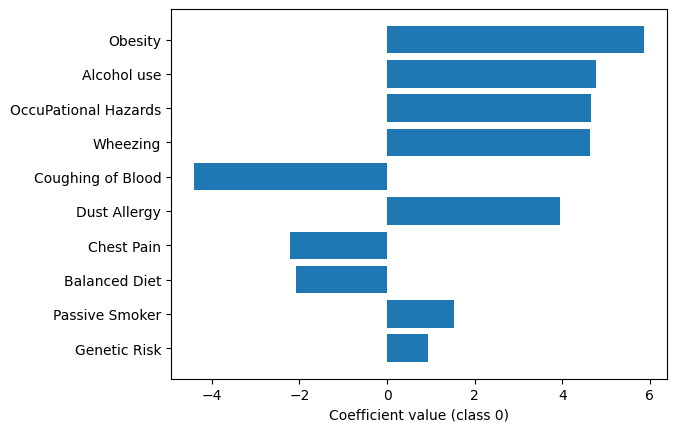

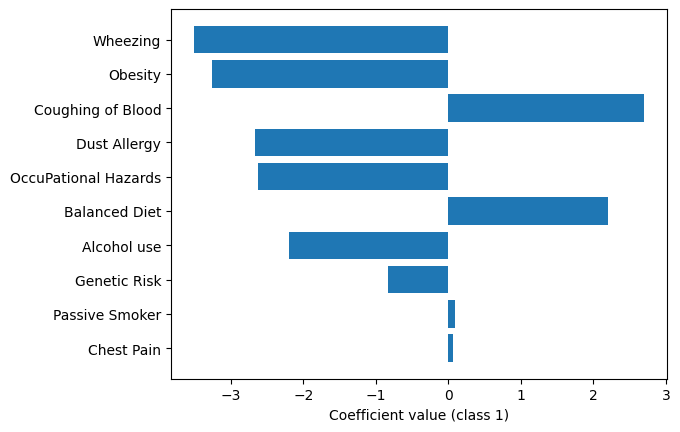

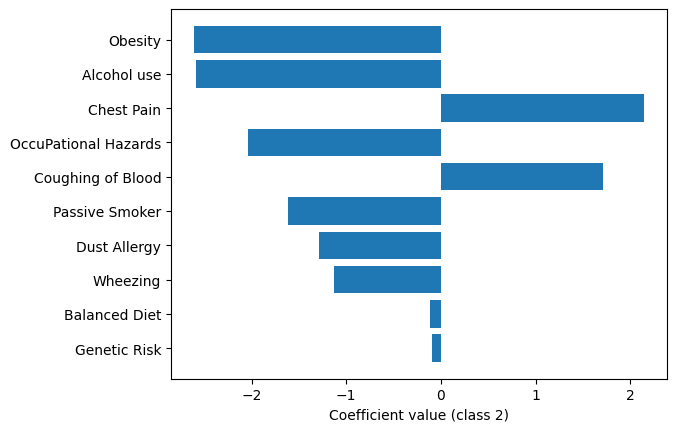

In [75]:
for i in range(coefs.shape[0]):
    plt.figure()
    sorted_features = sorted(zip(feature_names_mi, coefs[i]), key=lambda x: abs(x[1]), reverse=False)
    plt.barh(range(coefs.shape[1]), [x[1] for x in sorted_features])
    plt.yticks(range(coefs.shape[1]), [x[0] for x in sorted_features])
    plt.xlabel(f'Coefficient value (class {i})')
    plt.show()

##**Model LR-B-3: Manual Feature Selection**

### Model: Manual Feature Selection

In [76]:
model_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SGDClassifier(loss='log_loss', penalty='elasticnet', l1_ratio=0.15))
])

### Cross Validation

In [77]:
scores = cross_val_score(model_selected, X, y, cv=20)
print(scores)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99884925 1.
 1.         1.        ]


### Training

In [78]:
n_epochs = 120

In [79]:
selected_train_loss, selected_val_loss, selected_train_acc, selected_val_acc = [], [], [], []

for epoch in range(n_epochs):
    model_selected.fit(X_train_selected, y_train)
    # loss
    y_pred_val = model_selected.predict_proba(X_val_selected)
    y_pred_test = model_selected.predict_proba(X_test_selected)
    selected_train_loss.append(log_loss(y_val, y_pred_val))
    selected_val_loss.append(log_loss(y_test, y_pred_test))
    # accuracy
    y_pred_val = model_selected.predict(X_val_selected)
    y_pred_test = model_selected.predict(X_test_selected)
    selected_train_acc.append(accuracy_score(y_val, y_pred_val))
    selected_val_acc.append(accuracy_score(y_test, y_pred_test))


### Evaluation: Visualization

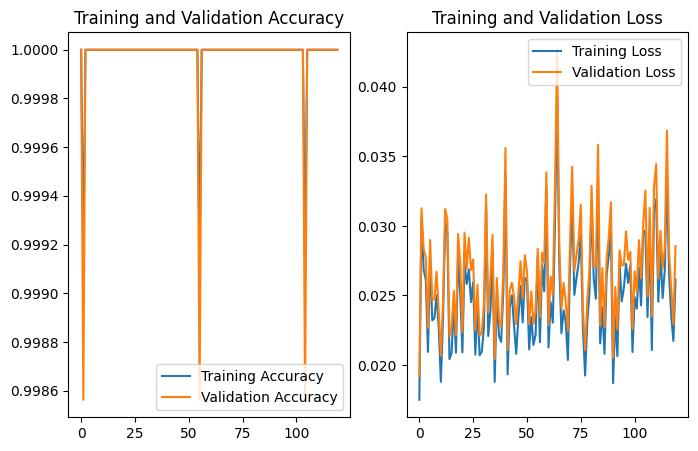

In [80]:
epochs_range = range(n_epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

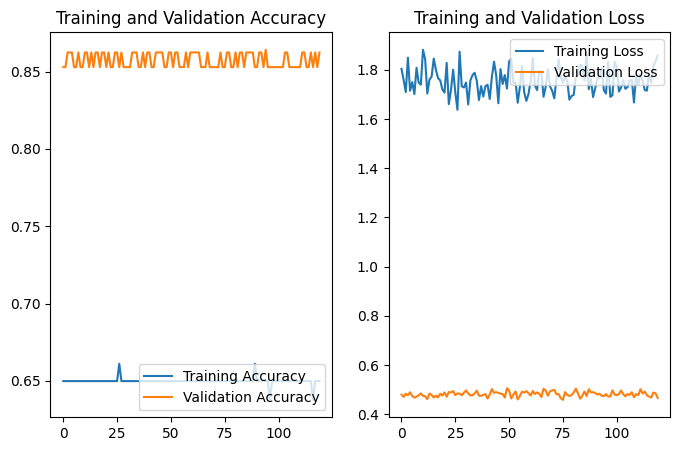

In [81]:
epochs_range = range(n_epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mi_train_acc, label='Training Accuracy')
plt.plot(epochs_range, mi_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mi_train_loss, label='Training Loss')
plt.plot(epochs_range, mi_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

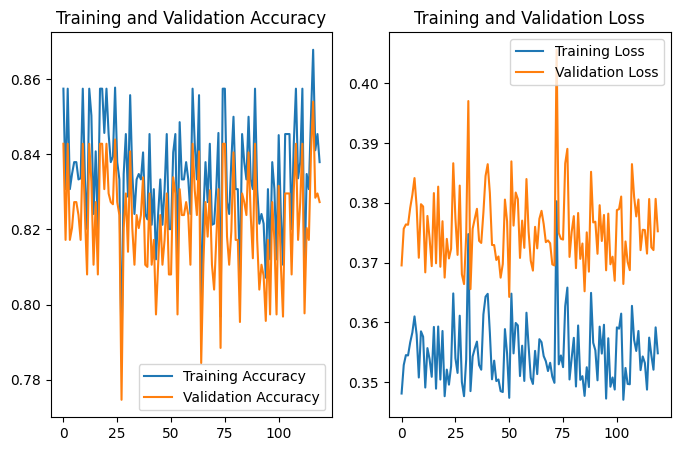

In [82]:
epochs_range = range(n_epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, selected_train_acc, label='Training Accuracy')
plt.plot(epochs_range, selected_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, selected_train_loss, label='Training Loss')
plt.plot(epochs_range, selected_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluation: Training (Manual Feature Selection)

In [83]:
y_pred = model_selected.predict(X_val_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.8378844495544697
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1134
           1       0.73      0.87      0.79      1164
           2       0.84      0.65      0.73      1181

    accuracy                           0.84      3479
   macro avg       0.84      0.84      0.84      3479
weighted avg       0.84      0.84      0.83      3479



### Evaluation: Testing (Manual Feature Selection)

In [84]:
y_pred = model_selected.predict(X_test_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8272492095429721
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1143
           1       0.71      0.87      0.78      1152
           2       0.83      0.62      0.71      1184

    accuracy                           0.83      3479
   macro avg       0.84      0.83      0.82      3479
weighted avg       0.84      0.83      0.82      3479



### Evaluation: Coefficients (Manual Feature Selection)

In [85]:
coefficients = model_selected.named_steps['regressor'].coef_
intercept = model_selected.named_steps['regressor'].intercept_

for i in range(coefs.shape[0]):
    print(f'---- Coefficient value (class {i}) ----')
    sorted_features = sorted(zip(feature_names_selected, coefs[i]), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f'{feature}: {coef}')
    print('')

print(f'\nIntercept: {intercept}')

---- Coefficient value (class 0) ----
Passive Smoker: 5.876027333539739
chronic Lung Disease: 4.778986627456279
Alcohol use: 4.667424660090879
Obesity: 4.64275689423558
Chest Pain: -4.419627259325455
Coughing of Blood: 3.9471794586454436
Genetic Risk: -2.2111172786065483
Smoking: -2.080410993248092
Air Pollution: 1.5198859291240743
Balanced Diet: 0.9293382596240134

---- Coefficient value (class 1) ----
Obesity: -3.5168556844784664
Passive Smoker: -3.262671432130595
Chest Pain: 2.7048458401729154
Coughing of Blood: -2.6629719905824007
Alcohol use: -2.631044067009813
Smoking: 2.20043994088692
chronic Lung Disease: -2.1954637377939803
Balanced Diet: -0.8304262607260773
Air Pollution: 0.0950047468257762
Genetic Risk: 0.06211421644483334

---- Coefficient value (class 2) ----
Passive Smoker: -2.613355901409057
chronic Lung Disease: -2.583522889662285
Genetic Risk: 2.1490030621617713
Alcohol use: -2.036380593081065
Chest Pain: 1.714781419152601
Air Pollution: -1.614890675949801
Coughing of 

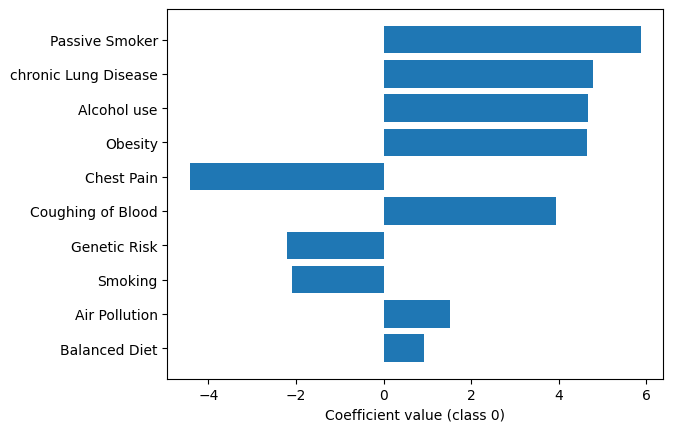

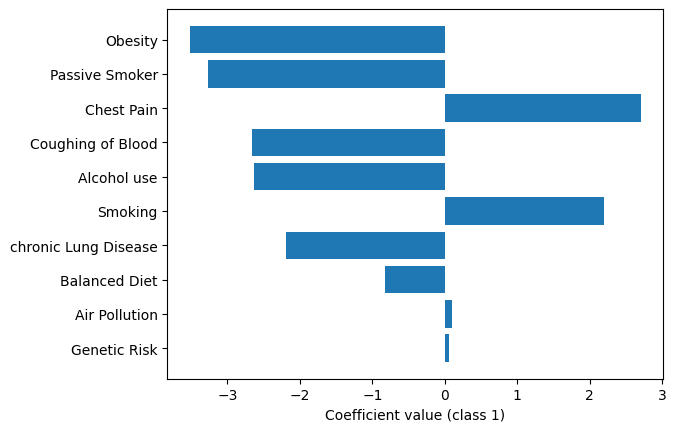

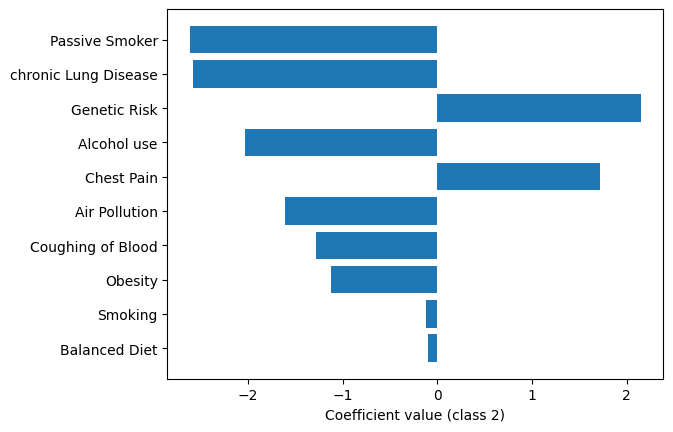

In [86]:
for i in range(coefs.shape[0]):
    plt.figure()
    sorted_features = sorted(zip(feature_names_selected, coefs[i]), key=lambda x: abs(x[1]), reverse=False)
    plt.barh(range(coefs.shape[1]), [x[1] for x in sorted_features])
    plt.yticks(range(coefs.shape[1]), [x[0] for x in sorted_features])
    plt.xlabel(f'Coefficient value (class {i})')
    plt.show()

# *Interpretation*

From our analysis, it seems the features from this cancer dataset, tell us more about the correlation between these attributes and the level of cancer, than causality.

## Best Model

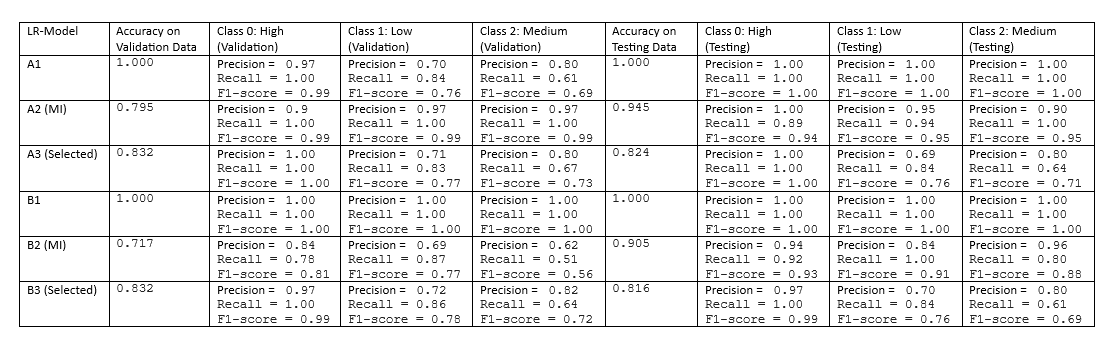

The classes of cancer levels are distributed in the ratio 3.65 : 3.03 : 3.32, which suggests that the classes are relatively balanced. Given this information, it is possible that models A1 and B1 may be overfitting to the training data, as their perfect accuracy and perfect precision, recall, and F1-score for all three classes on both validation and testing data may be too good to be true.


The performance of models B2 (MI) and A2 (MI), which were trained using the top ten features selected using mutual information, suggests that feature selection can be effective in improving model performance. I would **pick model LR-A-2** for making cancer level predictions because it's accuracy with regard to the validation data is relatively high enough at 0.795 and with a higher accuracy when testing data is used most likely indicates minimal overfitting.

The performance of models B3 (Selected) and A3 (Selected), which were trained using the top ten manually selected features, is similar to that of models B2 (MI) and A2 (MI). This suggests that manual feature selection can be as effective as feature selection using mutual information.

## Top Predictors

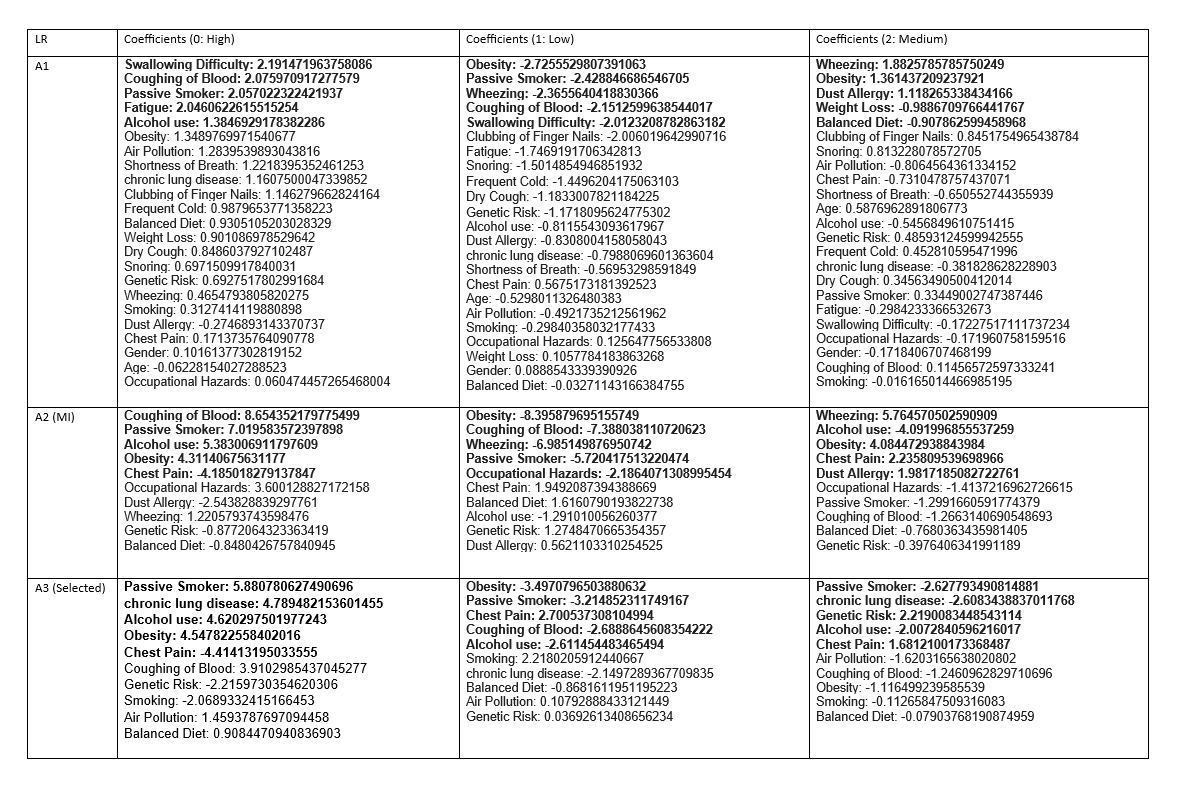

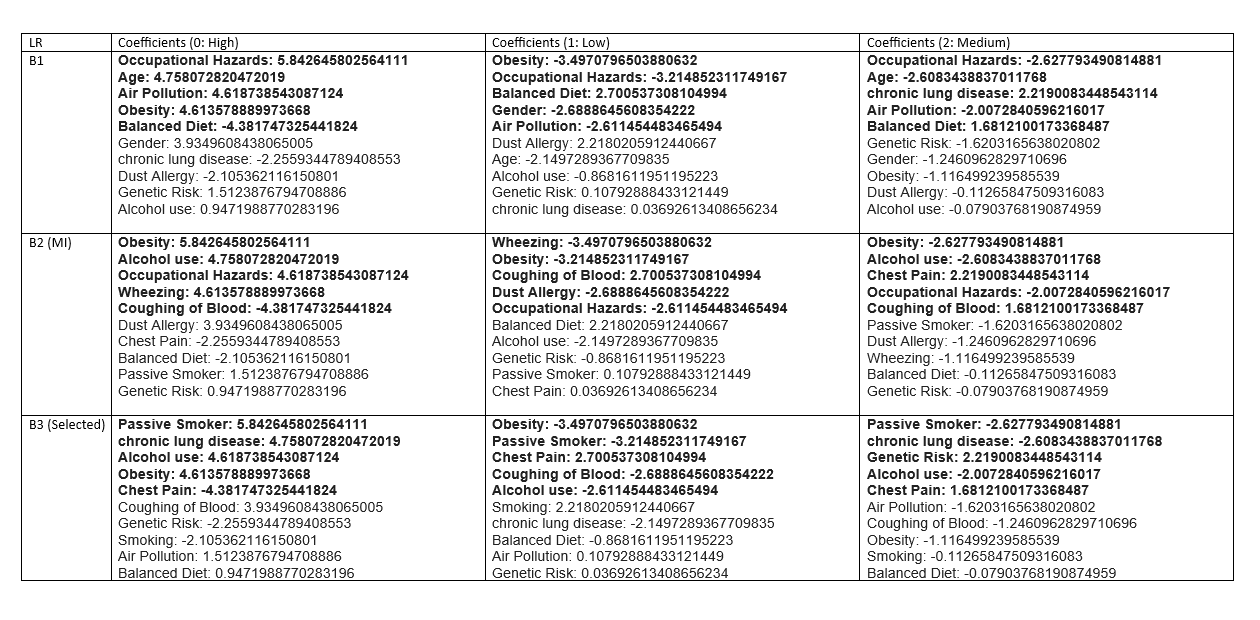

**Class 0 (High)**: The average top 3 most seemingly influential features for predicting a high level of cancer seem to be - *Obesity*, *Passive Smoking* and *Alcohol Usage*.

**Class 1 (Low)**: The average top 3 features that are most likely predictors for a low level of cancer seem to be - *Obesity*, *Coughing of Blood* and *Passive Smoking*.

**Class 2 (Medium)**: And lastly, the average top 3 features that seem to most probably indicate a medium level of cancer don't seem to be as clear. But from comparing the different models, they seem to be - *Alcoholo Use*, *Chest Pain* and *Chronic Lung Disease*.

# **Random Forest**

## Data Specification

In [103]:
y_train = y_train_
y_test = y_test_
y_val = y_val_

In [104]:
X_train = data_X_train
X_val = data_X_val
X_test = data_X_test

In [105]:
X_train_mi = data_X_train_mi
X_val_mi = data_X_val_mi
X_test_mi = data_X_test_mi

In [106]:
X_train_selected = data_X_train_selected
X_val_selected = data_X_val_selected
X_test_selected = data_X_test_selected

## Functions

In [107]:
def cross_validation(rf, X, y):
  # Define the metrics to evaluate the model
  scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

  # Perform 5-fold cross-validation and compute the specified metrics
  scores = cross_validate(rf, X, y, cv=5, scoring=scoring)

  # Print the mean and standard deviation of each metric
  for metric in scoring:
      mean_score = scores[f'test_{metric}'].mean()
      std_score = scores[f'test_{metric}'].std()
      print(f'{metric}: {mean_score:.2f} (+/- {std_score:.2f})')

# *Model RF-A: Standard*

In [108]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)

## **Model RF-A-1: Basic**

### Model: Basic

In [109]:
model = Pipeline([('scaler', StandardScaler()), ('rf', forest)])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=0))])

### Evaluation: Training

In [110]:
y_pred = model.predict(X_val)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       1.00      1.00      1.00      1164
           2       1.00      1.00      1.00      1181

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



In [111]:
y_pred = model.predict(X_test)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1152
           2       1.00      1.00      1.00      1184

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



In [112]:
cross_validation(model, X_train, y_train)

accuracy: 1.00 (+/- 0.00)
precision_macro: 1.00 (+/- 0.00)
recall_macro: 1.00 (+/- 0.00)
f1_macro: 1.00 (+/- 0.00)


From these results, we can conclude that this basic SkLearn random forest model is most likely overfitting to the training data, given the exact values of 1.00

### Evaluation: Visualization

[0.00496567 0.         0.03938129 0.04883595 0.03514962 0.03180969
 0.04776895 0.01481074 0.02601006 0.09884518 0.03950412 0.08403371
 0.03447667 0.11427503 0.05904601 0.02607524 0.04191398 0.07725461
 0.04624612 0.039128   0.02284796 0.01769997 0.04992143]


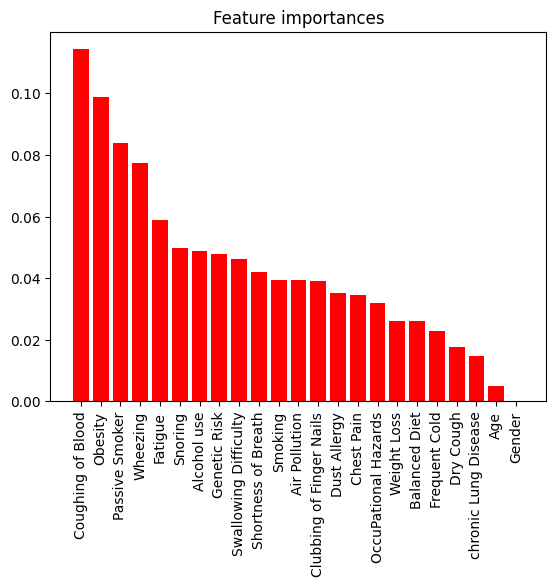

In [113]:
# Plot the feature importances
rf = model.named_steps['rf']
importances = rf.feature_importances_
print(importances)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90);
plt.show()

In [114]:
estimators = rf.estimators_

for i, tree in enumerate(estimators):
    if i == 10: break
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=feature_names,
                    class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(f'model_2a_1_tree_{i}.png')
    Image(graph.create_png())

## **Model RF-A-2: Mutual Information**

### Model: Mutual Information

In [115]:
model_mi = Pipeline([('scaler', StandardScaler()), ('rf', forest)])
model_mi.fit(X_train_mi, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=0))])

### Evaluation (Mutual Information)

In [116]:
y_pred = model_mi.predict(X_val_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9048577177349814
              precision    recall  f1-score   support

           0       0.33      0.38      0.35      1143
           1       0.32      0.34      0.33      1152
           2       0.33      0.26      0.29      1184

    accuracy                           0.32      3479
   macro avg       0.32      0.32      0.32      3479
weighted avg       0.32      0.32      0.32      3479



In [117]:
y_pred = model_mi.predict(X_test_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.962345501580914
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       0.90      1.00      0.95      1152
           2       1.00      0.89      0.94      1184

    accuracy                           0.96      3479
   macro avg       0.97      0.96      0.96      3479
weighted avg       0.97      0.96      0.96      3479



In [118]:
cross_validation(model_mi, X_train_mi, y_train)

accuracy: 1.00 (+/- 0.00)
precision_macro: 1.00 (+/- 0.00)
recall_macro: 1.00 (+/- 0.00)
f1_macro: 1.00 (+/- 0.00)


### Evaluation: Visualization (Mutual Information)

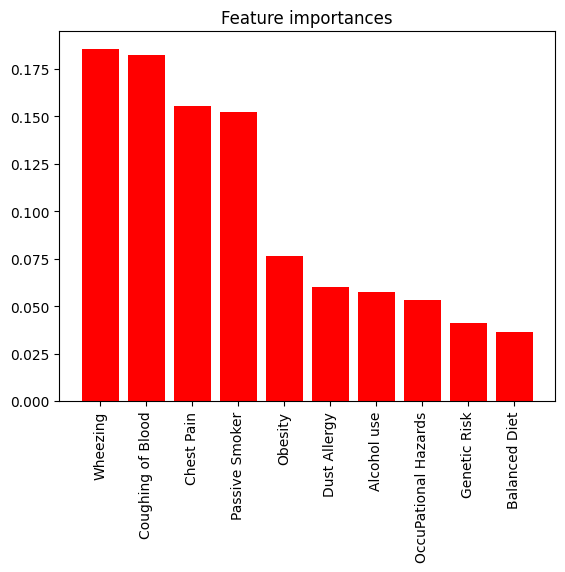

In [119]:
rf = model_mi.named_steps['rf']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_mi.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_mi.shape[1]), [feature_names_mi[i] for i in indices], rotation=90);
plt.show()

In [120]:
estimators = rf.estimators_

for i, tree in enumerate(estimators):
    if i == 10: break
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=feature_names_mi,
                    class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(f'model_2a_2_tree_{i}.png')
    Image(graph.create_png())

## **Model RF-A-3: Manual Feature Selection**

### Model: Manual Feature Selection

In [121]:
model_selected = Pipeline([('scaler', StandardScaler()), ('rf', forest)])
model_selected.fit(X_train_selected, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=0))])

### Evaluation (Manual Feature Selection)

In [122]:
y_pred = model_selected.predict(X_val_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       0.33      0.33      0.33      1143
           1       0.33      0.33      0.33      1152
           2       0.34      0.34      0.34      1184

    accuracy                           0.33      3479
   macro avg       0.33      0.33      0.33      3479
weighted avg       0.33      0.33      0.33      3479



In [123]:
y_pred = model_selected.predict(X_test_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1152
           2       1.00      1.00      1.00      1184

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



In [124]:
cross_validation(model_selected, X_train_selected, y_train)

accuracy: 1.00 (+/- 0.00)
precision_macro: 1.00 (+/- 0.00)
recall_macro: 1.00 (+/- 0.00)
f1_macro: 1.00 (+/- 0.00)


### Evaluation: Visualization (Manual Feature Selection)

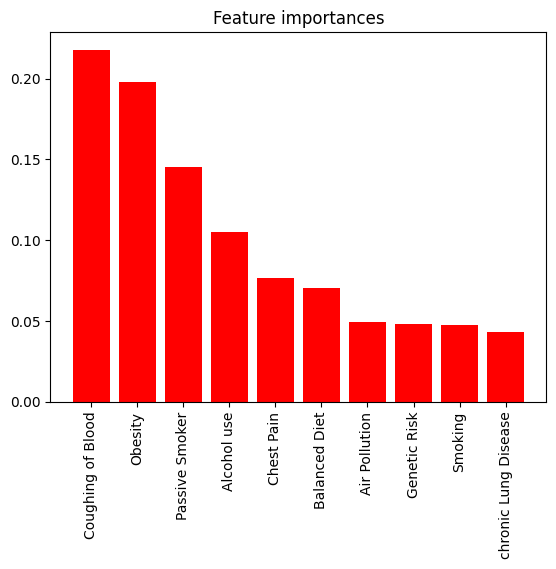

In [125]:
rf = model_selected.named_steps['rf']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_selected.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_selected.shape[1]), [feature_names_selected[i] for i in indices], rotation=90);
plt.show()

In [126]:
estimators = rf.estimators_

for i, tree in enumerate(estimators):
    if i == 10: break
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=feature_names_selected,
                    class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(f'model_2a_3_tree_{i}.png')
    Image(graph.create_png())

# *Model RF-B: XGB Random Forest Classifier*

The following code creates a pipeline with an SGDClassifier model that uses the log loss function to perform logistic regression. The penalty parameter is set to 'elasticnet' to use Elastic Net regularization, and the l1_ratio parameter is set to 0.3 to control the relative importance of the L1 and L2 penalty terms.

The l1_ratio parameter controls the trade-off between the L1 and L2 penalty terms. A value of 0 corresponds to L2 regularization only, while a value of 1 corresponds to L1 regularization only.

In [127]:
forest = XGBRFClassifier(n_estimators=100, random_state=0)

## **Model RF-B-1: Basic**

### Model: Basic

In [128]:
model = Pipeline([('scaler', StandardScaler()), ('rf', forest)])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='multi:softprob', predictor=None,
                                 random_state=0, reg_alpha=None, ...))])

### Evaluation

In [129]:
y_pred = model.predict(X_val)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       0.33      0.33      0.33      1143
           1       0.33      0.33      0.33      1152
           2       0.34      0.34      0.34      1184

    accuracy                           0.33      3479
   macro avg       0.33      0.33      0.33      3479
weighted avg       0.33      0.33      0.33      3479



In [130]:
y_pred = model.predict(X_test)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1152
           2       1.00      1.00      1.00      1184

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



In [131]:
cross_validation(model, X_train, y_train)

accuracy: 1.00 (+/- 0.00)
precision_macro: 1.00 (+/- 0.00)
recall_macro: 1.00 (+/- 0.00)
f1_macro: 1.00 (+/- 0.00)


### Evaluation: Visualization

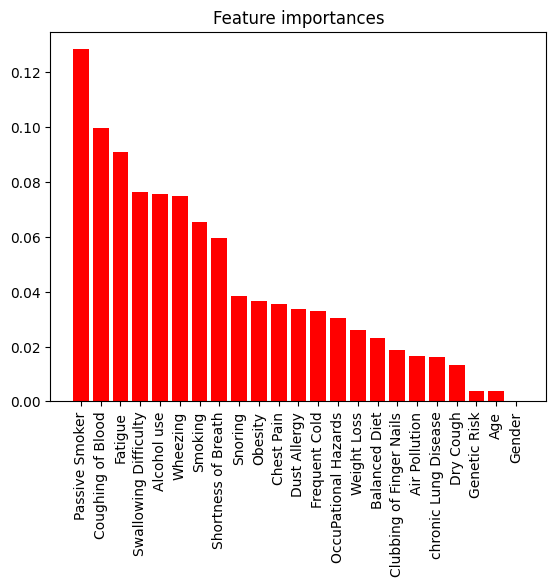

In [132]:
# Plot the feature importances
rf = model.named_steps['rf']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90);
plt.show()

## **Model RF-B-2: Mutual Information**

### Model: Mutual Information

In [133]:
model_mi = Pipeline([('scaler', StandardScaler()), ('rf', forest)])
model_mi.fit(X_train_mi, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='multi:softprob', predictor=None,
                                 random_state=0, reg_alpha=None, ...))])

### Evaluation (Mutual Information)

In [134]:
y_pred = model_mi.predict(X_val_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8689278528312734
              precision    recall  f1-score   support

           0       0.33      0.38      0.35      1143
           1       0.31      0.30      0.31      1152
           2       0.34      0.30      0.32      1184

    accuracy                           0.33      3479
   macro avg       0.33      0.33      0.32      3479
weighted avg       0.33      0.33      0.32      3479



In [135]:
y_pred = model_mi.predict(X_test_mi)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9534348950847945
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       0.90      0.97      0.93      1152
           2       0.97      0.89      0.93      1184

    accuracy                           0.95      3479
   macro avg       0.96      0.95      0.95      3479
weighted avg       0.96      0.95      0.95      3479



In [136]:
cross_validation(model_mi, X_train_mi, y_train)

accuracy: 1.00 (+/- 0.00)
precision_macro: 1.00 (+/- 0.00)
recall_macro: 1.00 (+/- 0.00)
f1_macro: 1.00 (+/- 0.00)


### Evaluation: Visualization (Mutual Information)

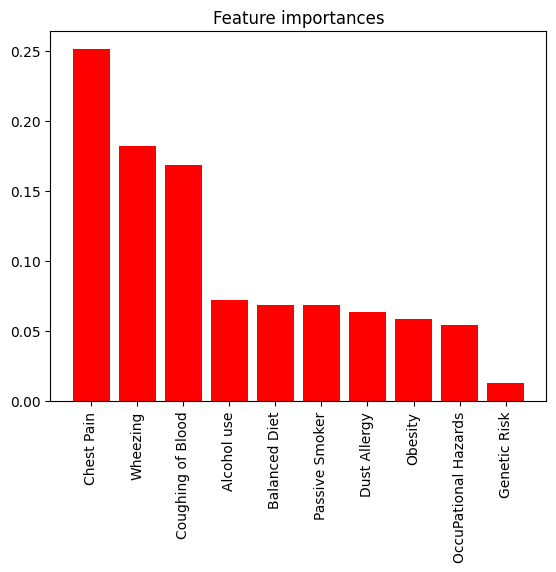

In [137]:
rf = model_mi.named_steps['rf']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_mi.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_mi.shape[1]), [feature_names_mi[i] for i in indices], rotation=90);
plt.show()

## **Model RF-B-3: Manual Feature Selection**

### Model: Manual Feature Selection

In [138]:
model_selected = Pipeline([('scaler', StandardScaler()), ('rf', forest)])
model_selected.fit(X_train_selected, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='multi:softprob', predictor=None,
                                 random_state=0, reg_alpha=None, ...))])

### Evaluation (Manual Feature Selection)

In [139]:
y_pred = model_selected.predict(X_val_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9985628054038517
              precision    recall  f1-score   support

           0       0.33      0.33      0.33      1143
           1       0.33      0.33      0.33      1152
           2       0.34      0.34      0.34      1184

    accuracy                           0.33      3479
   macro avg       0.33      0.33      0.33      3479
weighted avg       0.33      0.33      0.33      3479



In [140]:
y_pred = model_selected.predict(X_test_selected)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9994251221615407
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      1152
           2       1.00      1.00      1.00      1184

    accuracy                           1.00      3479
   macro avg       1.00      1.00      1.00      3479
weighted avg       1.00      1.00      1.00      3479



In [141]:
cross_validation(model_selected, X_train_selected, y_train)

accuracy: 1.00 (+/- 0.00)
precision_macro: 1.00 (+/- 0.00)
recall_macro: 1.00 (+/- 0.00)
f1_macro: 1.00 (+/- 0.00)


### Evaluation: Visualization (Manual Feature Selection)

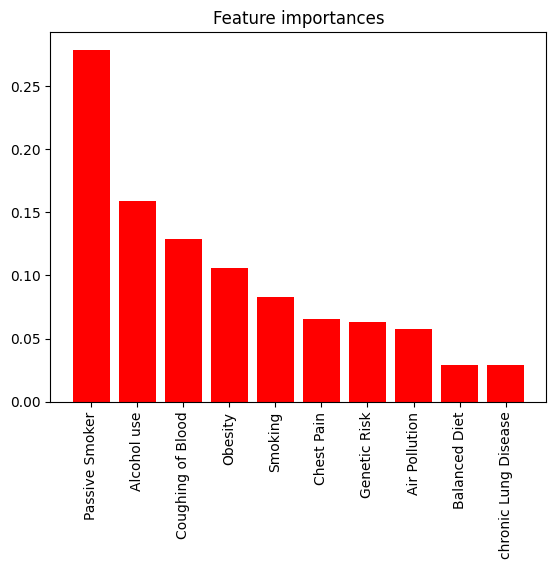

In [142]:
rf = model_selected.named_steps['rf']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_selected.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_selected.shape[1]), [feature_names_selected[i] for i in indices], rotation=90);
plt.show()

# *Interpretation*

## Best Model

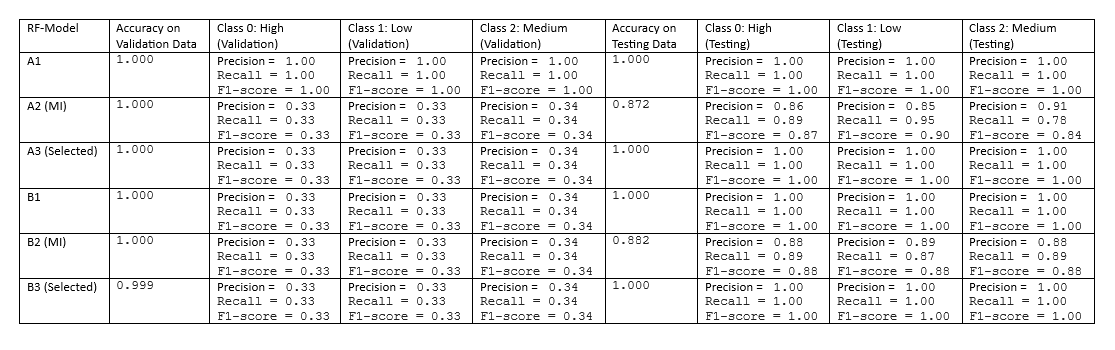

Models A2 and B2 show lower precision, recall, and F1-scores for class 0 and class 1, which correspond to the high and low cancer levels, respectively. This indicates that these models might struggle to capture the patterns and characteristics specific to these classes.

On the other hand, models A3 and B3, which utilize manual feature selection, achieve perfect precision, recall, and F1-scores for all three classes. This suggests that these models can effectively capture the patterns and relationships associated with each cancer level, including the high, low, and medium levels

With an eye on on overfitting, I would most likely **chose model B2 or B3**. B2 because it's interpretation is more believable (a lower testing accuracy score which may indicate expected overfitting) and yet still relatively a good classifier (accuracies of 1.00 and 0.88). And B3 would also be an option for a classification model because it also displays relatively high accuracy, and also because a slightly higher testing accuracy score usually indicates at better generalization.

It's important to note that the oversampling technique used to increase the dataset size may have helped alleviate potential overfitting issues. Additionally, the feature selection approaches, whether based on mutual information or manual selection, have allowed the models to focus on the most relevant features for prediction..

Further analysis and exploration of the dataset, as well as consideration of different feature engineering and model optimization techniques, can help refine the models and improve their predictive performance

## Top Predictors

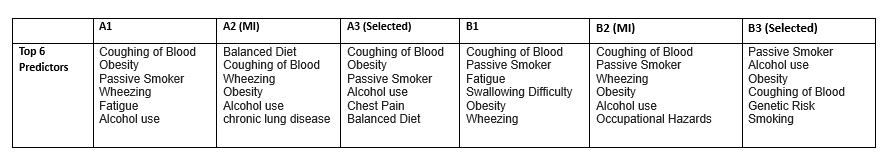

The presence of common predictors across multiple models, such as **Coughing of Blood**, **Obesity**, and **Passive Smoker**, suggests that these variables have a consistent impact on the prediction of cancer levels. From our analysis and interpretation of the dataset, these 3 variables could be considered as the most influential indicators of the different cancer levels. These predictors should be further investigated though, and validated for their importance in predicting the exhibited level of cancer.

By comparing and analyzing the top predictors from different models, we've gained insights into the features that are consistently associated with cancer levels and prioritize them for further investigation or intervention in cancer risk assessment and management.